In [17]:
from collections import Counter
from pathlib import Path

from tqdm import tqdm
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from torchvision import transforms as T
from torchvision.utils import make_grid
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import NearestNeighbors


%matplotlib inline

## Utils

In [18]:
def show_cluster(cluster, labels, dataset, limit=32):
    images = []
    labels = np.array(labels)
    indices = np.where(labels==cluster)[0]
    
    if not indices.size:
        print(f'cluster: {cluster} is empty.')
        return None
    
    for i in indices[:limit]:
        image, _ = dataset[i]
        images.append(image)
        
    gridded = make_grid(images)
    plt.figure(figsize=(15, 10))
    plt.title(f'cluster: {cluster}')
    plt.imshow(gridded.permute(1, 2, 0))
    plt.axis('off')
    
    
def show_neighbors(neighbors, dataset):
    images = []
    for n in neighbors:
        images.append(dataset[n][0])

    gridded = make_grid(images)
    plt.figure(figsize=(15, 10))
    plt.title(f'image and nearest neighbors')
    plt.imshow(gridded.permute(1, 2, 0))

In [19]:
def extract_features(model, dataset, batch_size=32):
    """
    Gets the output of a pytorch model given a dataset.
    """
    loader = DataLoader(dataset, batch_size=batch_size)
    features = []
    for image, _ in tqdm(loader, desc='extracting features'):
        output = model(Variable(image).cuda())
        features.append(output.data.cpu())
    print(output)
    return torch.cat(features).numpy()

## Dataset and transforms

In [20]:
class ForestDataset(Dataset):
    def __init__(self, root, transforms=None, labels=[], limit=None):
        self.root = Path(root)
        self.image_paths = list(Path(root).glob('*.jpg'))
        if limit:
            self.image_paths = self.image_paths[:limit]
        self.labels = labels
        self.transforms = transforms
        self.classes = set([path.parts[-2] for path in self.image_paths])
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index] if self.labels else 0
        image = Image.open(image_path)
        if self.transforms:
            return self.transforms(image), label
        return image, label
            
    def __len__(self):
        return len(self.image_paths)    
    
transforms = T.Compose([T.Resize(224),
                        T.CenterCrop(224),
                        T.ToTensor()])

## Config

In [21]:
# data
root = '../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images'
limit_images = 10000

# clustering
pca_dim = 50
kmeans_clusters = 100

# convnet
batch_size = 64
num_classes = 100
num_epochs = 2


## Data
Food Dataset, 101 different foods, 1000 samples each.

We will use then first 10 classes to test this method.

In [22]:
dataset = ForestDataset(root=root, limit=limit_images)

In [23]:
model = resnet18()
model.fc = nn.Linear(512, num_classes)
model.cuda();

loader = DataLoader(dataset, batch_size=batch_size)
features = []

In [24]:
loader

In [25]:
#output = model(Variable(image).cuda())

In [26]:
#dataset.classes

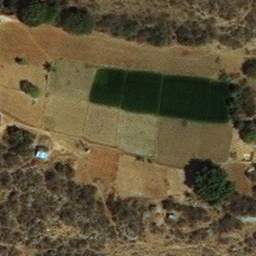

In [27]:
image, _ = dataset[5000]
image

## Models

In [28]:
# load resnet and alter last layer
model = resnet18()
model.fc = nn.Linear(512, num_classes)
model.cuda();

pca = IncrementalPCA(n_components=pca_dim, batch_size=512, whiten=True)
kmeans = MiniBatchKMeans(n_clusters=kmeans_clusters, batch_size=512, init_size=3*kmeans_clusters)
optimizer = Adam(model.parameters())

# clustering loop

In [29]:
def cluster(pca, kmeans, model, dataset, batch_size, return_features=False):
    features = extract_features(model, dataset, batch_size)  
    reduced = pca.fit_transform(features)
    pseudo_labels = list(kmeans.fit_predict(reduced))
    print("pseudo_labels ", pseudo_labels)
    if return_features:
        return pseudo_labels, features
    return pseudo_labels

## Training loop

In [30]:
def train_epoch(model, optimizer, train_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    total_loss = 0
    pbar = tqdm(train_loader)
    for batch, (images, labels) in enumerate(pbar):
        optimizer.zero_grad()
        images = Variable(images).cuda()
        labels = Variable(labels).cuda().long()
        out = model(images)
        loss = F.cross_entropy(out, labels)
        total_loss += loss.data[0]
        pbar.set_description(f'training - loss: {total_loss / (batch + 1)}')
        loss.backward()
        optimizer.step()

## Check how images are clustered with random convnet

In [31]:
raw_dataset = ForestDataset(root=root, transforms=transforms, limit=limit_images)
pseudo_labels, features = cluster(pca, kmeans, model, raw_dataset, batch_size, return_features=True)

extracting features: 100%|██████████| 80/80 [00:37<00:00,  2.12it/s]


tensor([[-0.5464,  0.6592,  0.4019,  ..., -1.6285, -1.2533,  0.4741],
        [-0.1424,  0.0155,  0.4215,  ..., -0.8704, -0.4346,  0.3171],
        [-0.0875,  0.2077,  0.4543,  ..., -0.8370, -0.3210,  0.4505],
        ...,
        [-0.2811,  0.1609,  0.3786,  ..., -0.9032, -0.5251,  0.4766],
        [-0.2319,  0.2616,  0.4864,  ..., -0.9309, -0.4447,  0.5624],
        [-0.7153,  0.2756,  0.4293,  ..., -1.3481, -0.9595,  0.4347]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)
pseudo_labels  [90, 6, 47, 30, 7, 17, 26, 7, 30, 8, 7, 75, 22, 74, 0, 74, 3, 7, 19, 70, 45, 14, 5, 11, 60, 61, 74, 14, 30, 67, 23, 14, 45, 3, 19, 56, 41, 22, 7, 45, 44, 8, 7, 58, 6, 33, 63, 74, 39, 3, 14, 6, 14, 7, 6, 14, 45, 6, 2, 2, 33, 0, 72, 90, 3, 84, 45, 14, 74, 19, 7, 8, 66, 19, 45, 90, 6, 14, 16, 26, 53, 2, 6, 51, 70, 14, 30, 2, 89, 4, 32, 7, 22, 2, 68, 41, 8, 63, 66, 74, 89, 14, 6, 45, 8, 18, 52, 5, 70, 12, 14, 22, 52, 5, 17, 14, 45, 89, 39, 14, 97, 6, 19, 30, 90, 45, 39, 33, 48, 94, 6, 5, 90, 5, 2, 9

### Cluster distributions

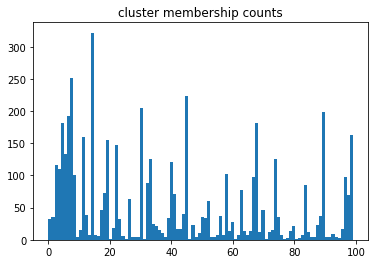

In [32]:
plt.hist(pseudo_labels, bins=kmeans_clusters)
plt.title('cluster membership counts');

### largest clusters

In [33]:
raw_dataset.classes ## all food types we have sampled

{'images'}

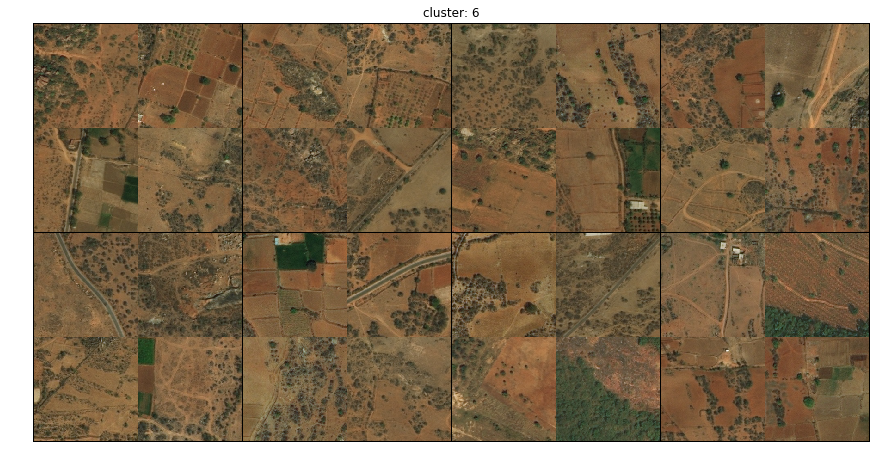

In [34]:
counts = Counter(pseudo_labels)
show_cluster(counts.most_common()[5][0], pseudo_labels, raw_dataset)

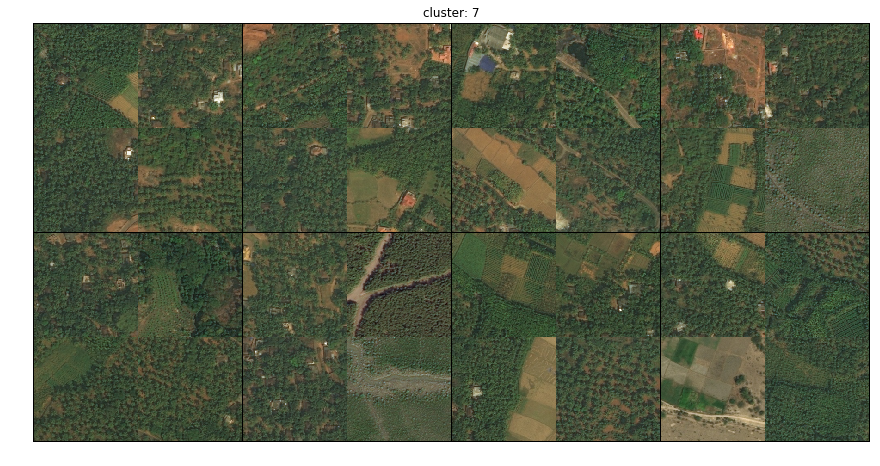

In [35]:
show_cluster(counts.most_common()[1][0], pseudo_labels, raw_dataset)

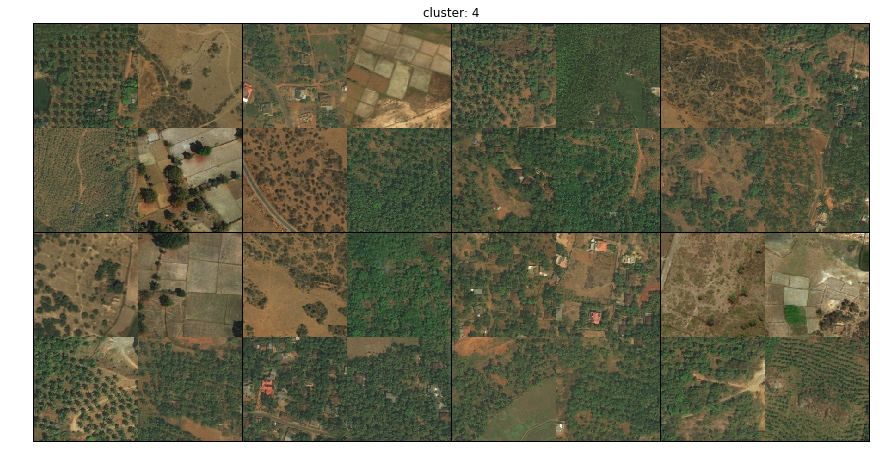

In [36]:
show_cluster(counts.most_common()[6][0], pseudo_labels, raw_dataset)

## image retrieval on with random model

In [37]:
knn = NearestNeighbors(metric='cosine')
knn.fit(features)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

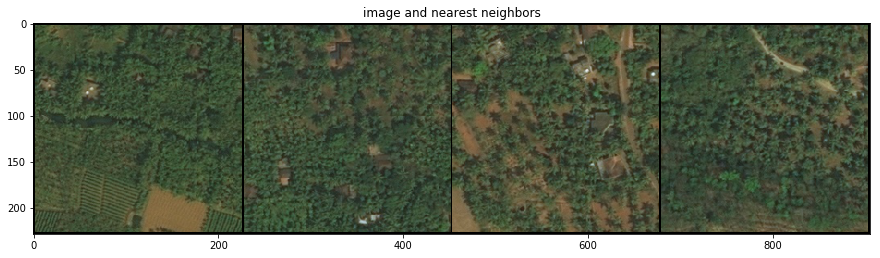

In [38]:
anchor_image = 0
neighbors = knn.kneighbors([features[anchor_image]], n_neighbors=4, return_distance=False)[0]
show_neighbors(neighbors, raw_dataset)

## Full Cycle

In [ ]:
for i in range(100):
    pseudo_labels = cluster(pca, kmeans, model, raw_dataset, batch_size) # generate labels
    labeled_dataset = ForestDataset(root=root, labels=pseudo_labels, transforms=transforms, limit=limit_images) # make new dataset with labels matched to images
    train_epoch(model, optimizer, labeled_dataset, batch_size) # train for one epoch

extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s]


tensor([[-0.5464,  0.6592,  0.4019,  ..., -1.6285, -1.2533,  0.4741],
        [-0.1424,  0.0155,  0.4215,  ..., -0.8704, -0.4346,  0.3171],
        [-0.0875,  0.2077,  0.4543,  ..., -0.8370, -0.3210,  0.4505],
        ...,
        [-0.2811,  0.1609,  0.3786,  ..., -0.9032, -0.5251,  0.4766],
        [-0.2319,  0.2616,  0.4864,  ..., -0.9309, -0.4447,  0.5624],
        [-0.7153,  0.2756,  0.4293,  ..., -1.3481, -0.9595,  0.4347]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [28, 33, 43, 80, 8, 8, 3, 20, 9, 93, 34, 61, 93, 7, 25, 63, 35, 22, 22, 0, 31, 21, 80, 18, 18, 96, 18, 26, 59, 76, 32, 80, 31, 63, 18, 27, 3, 93, 13, 25, 21, 48, 20, 80, 33, 62, 55, 18, 40, 22, 26, 32, 26, 27, 33, 26, 8, 93, 1, 1, 4, 31, 94, 26, 35, 33, 85, 26, 18, 18, 28, 59, 64, 18, 8, 26, 69, 26, 21, 13, 75, 62, 33, 21, 7, 26, 9, 1, 36, 93, 48, 28, 59, 31, 34, 23, 76, 46, 6, 47, 43, 26, 27, 27, 16, 95, 35, 31, 7, 74, 26, 94, 22, 59, 13, 26, 63, 20, 22, 26, 59, 93, 18, 9, 80, 31, 14, 62, 66, 43, 62, 31, 26, 13, 43, 64, 19, 53, 28, 18, 35, 43, 7, 34, 94, 95, 75, 43, 26, 27, 63, 27, 27, 59, 9, 93, 1, 62, 3, 27, 2, 33, 96, 7, 7, 62, 16, 26, 8, 74, 34, 4, 61, 29, 8, 85, 62, 20, 34, 80, 22, 26, 68, 53, 80, 34, 94, 74, 36, 8, 62, 26, 31, 26, 46, 55, 63, 19, 55, 73, 63, 8, 4, 43, 35, 21, 22, 63, 97, 64, 31, 9, 62, 72, 68, 33, 20, 18, 62, 95, 16, 17, 22, 21, 34, 5, 2, 93, 99, 33, 18, 62, 47, 59, 27, 70, 26, 62, 37, 28, 67, 55, 26, 63, 13, 80, 73, 21, 59, 27, 4, 13, 3, 4, 63, 7

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-1.3032, -3.7436, -1.9163,  ..., -0.7308, -1.7107, -3.4699],
        [-2.4281,  5.4088, -1.8898,  ..., -2.8415, -0.9424, -0.4270],
        [-0.2371,  2.4922, -2.7591,  ..., -2.2871, -1.7048, -0.8057],
        ...,
        [-3.1613, -1.3119, -3.8940,  ..., -5.4477,  0.6900, -1.4320],
        [ 0.0378,  0.8193, -2.5491,  ..., -1.8416, -1.8491, -0.8507],
        [-0.9822, -1.3124, -1.8981,  ..., -1.1260, -1.1417,  0.0572]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [34, 51, 91, 42, 99, 66, 49, 83, 40, 51, 15, 46, 75, 53, 16, 80, 22, 4, 81, 64, 79, 2, 35, 11, 54, 63, 1, 34, 40, 26, 17, 21, 91, 66, 78, 95, 84, 41, 26, 81, 19, 27, 86, 57, 0, 69, 56, 37, 76, 4, 7, 5, 62, 4, 41, 30, 71, 54, 72, 6, 1, 15, 81, 60, 51, 3, 5, 2, 38, 28, 11, 36, 99, 78, 67, 2, 5, 26, 31, 59, 50, 6, 14, 43, 37, 2, 68, 43, 23, 60, 31, 99, 61, 23, 4, 79, 94, 30, 84, 62, 69, 7, 41, 53, 23, 12, 69, 2, 53, 25, 2, 41, 66, 91, 2, 7, 26, 53, 36, 7, 99, 14, 26, 68, 2, 84, 15, 6, 22, 84, 5, 84, 30, 2, 20, 13, 38, 46, 99, 37, 76, 67, 53, 74, 41, 12, 95, 90, 83, 83, 26, 83, 6, 74, 89, 41, 43, 54, 40, 90, 92, 14, 63, 20, 5, 54, 80, 1, 11, 38, 4, 1, 46, 23, 94, 51, 23, 15, 26, 21, 76, 21, 0, 98, 21, 67, 41, 97, 42, 6, 43, 60, 41, 2, 7, 56, 74, 15, 7, 58, 75, 15, 71, 15, 22, 91, 4, 4, 49, 4, 2, 9, 43, 74, 0, 0, 83, 60, 6, 81, 18, 51, 31, 34, 74, 23, 92, 23, 74, 0, 28, 5, 60, 35, 16, 24, 62, 5, 59, 34, 64, 70, 34, 80, 2, 32, 97, 69, 79, 83, 75, 71, 2, 67, 69, 33, 62, 26, 74,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


tensor([[-3.9849, -2.5818, -1.5846,  ...,  1.9589, -5.5406, -4.5882],
        [-2.0658,  2.3753,  0.5613,  ..., -5.5420,  0.3683, -4.4134],
        [ 3.0810,  1.4280, -0.7571,  ..., -4.8142, -3.2359, -5.0976],
        ...,
        [-5.3610, -0.2492,  2.9181,  ..., -5.9586, -3.0701,  6.3829],
        [ 2.6605,  0.0488, -1.0604,  ..., -3.7041, -4.1658, -4.9664],
        [-3.4290, -0.9982, -0.5251,  ..., -1.3734, -4.6152, -5.2929]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [79, 2, 65, 87, 37, 8, 34, 13, 23, 72, 13, 67, 44, 3, 0, 12, 38, 44, 94, 41, 5, 95, 23, 31, 49, 83, 45, 39, 68, 34, 75, 69, 81, 81, 16, 85, 82, 2, 34, 9, 42, 67, 37, 0, 72, 2, 73, 3, 83, 44, 55, 58, 45, 92, 2, 59, 60, 72, 36, 5, 95, 79, 24, 4, 83, 58, 12, 6, 12, 39, 6, 14, 78, 16, 92, 45, 58, 39, 28, 61, 35, 91, 63, 91, 27, 95, 33, 91, 65, 43, 81, 37, 37, 65, 42, 5, 24, 59, 7, 45, 30, 55, 9, 63, 9, 40, 38, 25, 3, 16, 95, 81, 81, 81, 42, 39, 25, 25, 14, 59, 37, 72, 39, 16, 13, 44, 62, 91, 17, 7, 84, 7, 55, 46, 86, 96, 80, 67, 37, 3, 81, 92, 3, 92, 30, 94, 35, 95, 55, 46, 43, 3, 5, 19, 90, 2, 50, 49, 19, 42, 11, 72, 48, 27, 58, 91, 9, 95, 13, 52, 43, 44, 67, 9, 9, 47, 2, 79, 13, 39, 5, 39, 27, 33, 69, 92, 9, 22, 87, 91, 63, 71, 12, 95, 55, 15, 6, 13, 45, 85, 42, 31, 87, 62, 86, 36, 62, 44, 82, 92, 46, 64, 50, 34, 27, 58, 13, 43, 5, 94, 16, 47, 1, 13, 82, 65, 88, 65, 54, 58, 31, 84, 4, 23, 32, 27, 59, 84, 22, 4, 41, 73, 55, 81, 46, 69, 57, 2, 5, 13, 44, 74, 46, 52, 86, 76, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s]


tensor([[ 0.2407, -4.0002, -3.7269,  ...,  1.0207, -5.9120,  1.2155],
        [-3.9987,  1.6119, -2.4279,  ..., -4.8466,  0.1113, -4.1583],
        [-2.7948, -0.5010,  1.2296,  ..., -1.3476, -0.1737, -3.4446],
        ...,
        [ 0.2257, -2.6297, -4.8240,  ..., -4.6134, -3.7650, -2.7632],
        [-2.9965, -0.1103,  2.9350,  ..., -1.1589, -1.6208, -3.3869],
        [-2.9295,  1.0647,  1.9448,  ..., -1.9992, -3.6998, -2.1638]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [76, 30, 24, 67, 14, 66, 71, 1, 17, 62, 27, 19, 1, 33, 94, 33, 42, 1, 64, 80, 62, 28, 90, 74, 13, 23, 33, 74, 17, 54, 12, 67, 82, 20, 45, 73, 71, 96, 71, 21, 83, 58, 60, 90, 11, 57, 76, 2, 5, 1, 25, 30, 7, 24, 10, 7, 76, 57, 15, 4, 7, 81, 66, 7, 20, 30, 2, 8, 83, 74, 81, 89, 94, 45, 27, 28, 30, 25, 16, 51, 99, 91, 57, 91, 11, 28, 67, 61, 77, 25, 24, 67, 92, 26, 51, 91, 21, 7, 51, 7, 77, 25, 24, 11, 24, 12, 42, 1, 11, 65, 36, 24, 20, 24, 1, 25, 36, 2, 89, 7, 92, 2, 78, 70, 81, 51, 14, 91, 66, 20, 30, 51, 7, 71, 82, 92, 80, 78, 92, 13, 42, 1, 24, 27, 10, 55, 6, 36, 25, 32, 76, 36, 63, 92, 78, 68, 75, 53, 58, 32, 50, 57, 87, 93, 2, 53, 47, 97, 81, 65, 1, 28, 19, 24, 24, 53, 57, 81, 36, 78, 4, 26, 93, 26, 67, 27, 83, 79, 90, 91, 75, 76, 96, 25, 76, 33, 27, 80, 25, 41, 13, 8, 69, 14, 10, 62, 60, 1, 54, 27, 32, 70, 75, 69, 11, 82, 1, 26, 4, 55, 79, 20, 43, 81, 69, 91, 49, 24, 58, 2, 78, 30, 33, 17, 54, 11, 7, 68, 84, 76, 82, 14, 25, 88, 71, 34, 59, 77, 62, 36, 13, 14, 27, 72, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-1.6787, -6.8988, -5.0880,  ..., -4.9150, -0.7098, -0.5143],
        [-1.1305,  0.5773, -0.6458,  ...,  3.5982, -1.2984, -4.5868],
        [-1.8247, -3.6226,  4.8787,  ...,  1.3742, -4.0116, -3.8077],
        ...,
        [ 0.7041, -2.1863, -3.5877,  ..., -6.2104, -5.9789, -5.3192],
        [-1.9865, -3.1523,  3.7281,  ..., -0.4481, -3.6615, -3.8015],
        [-1.0077,  1.1318, -2.6391,  ..., -1.5372, -0.4071, -2.9922]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [35, 38, 58, 4, 25, 53, 84, 20, 0, 38, 20, 85, 97, 1, 26, 37, 74, 5, 51, 22, 28, 75, 0, 92, 3, 76, 11, 13, 0, 76, 61, 4, 48, 79, 34, 6, 75, 15, 71, 21, 3, 85, 25, 77, 99, 49, 35, 37, 27, 5, 19, 61, 59, 15, 8, 59, 35, 30, 40, 48, 91, 18, 82, 59, 31, 61, 61, 43, 98, 13, 43, 28, 43, 34, 5, 59, 61, 19, 33, 89, 12, 66, 99, 66, 37, 63, 54, 86, 38, 19, 74, 43, 9, 30, 5, 66, 73, 59, 84, 36, 49, 59, 58, 1, 58, 41, 16, 5, 1, 29, 37, 58, 88, 66, 78, 19, 5, 51, 28, 59, 9, 30, 50, 70, 43, 5, 43, 66, 53, 79, 61, 84, 59, 71, 1, 72, 98, 85, 44, 37, 74, 5, 37, 2, 41, 51, 57, 3, 19, 20, 93, 37, 27, 71, 50, 8, 80, 81, 55, 78, 45, 30, 67, 23, 30, 81, 21, 91, 68, 29, 63, 3, 85, 21, 26, 31, 8, 18, 37, 13, 38, 13, 23, 4, 92, 20, 41, 90, 52, 86, 80, 36, 58, 91, 35, 37, 55, 15, 91, 83, 3, 78, 72, 92, 38, 28, 15, 63, 21, 2, 63, 70, 80, 73, 23, 38, 20, 37, 27, 51, 77, 31, 74, 68, 71, 73, 45, 58, 88, 30, 13, 8, 59, 0, 76, 23, 59, 8, 90, 68, 23, 4, 19, 58, 75, 4, 87, 8, 48, 20, 3, 9, 93, 29, 49, 42,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


tensor([[-2.4728, -3.3112, -1.6485,  ..., -1.3095, -3.8977, -1.5477],
        [-3.3830,  0.5039, -0.1489,  ..., -0.3285, -2.7202, -2.0364],
        [-4.0495,  3.3024,  0.3667,  ...,  0.8154,  0.8248,  2.6732],
        ...,
        [ 1.8745, -1.4459,  1.3991,  ..., -3.8013, -1.4805, -4.3068],
        [-3.8476,  2.2776, -0.1881,  ...,  1.3708,  0.1007,  2.3584],
        [-3.3106, -1.2415, -1.2236,  ...,  2.0133, -0.3055, -0.7871]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [10, 5, 22, 61, 81, 83, 11, 1, 13, 4, 1, 89, 6, 51, 11, 38, 39, 21, 70, 32, 98, 73, 61, 62, 6, 69, 9, 40, 61, 50, 32, 62, 4, 39, 20, 25, 73, 6, 73, 72, 88, 89, 86, 36, 90, 54, 7, 38, 80, 1, 28, 45, 17, 21, 5, 17, 7, 47, 26, 4, 17, 10, 78, 17, 95, 41, 41, 84, 38, 40, 84, 68, 62, 65, 46, 9, 45, 28, 98, 36, 27, 85, 47, 44, 38, 63, 61, 85, 60, 28, 83, 62, 53, 56, 21, 4, 75, 92, 11, 9, 52, 17, 54, 8, 43, 48, 52, 21, 38, 65, 28, 54, 43, 44, 63, 28, 40, 54, 68, 17, 84, 56, 79, 59, 84, 21, 84, 44, 93, 95, 45, 21, 17, 73, 56, 18, 40, 89, 35, 38, 83, 10, 38, 16, 48, 70, 97, 63, 58, 28, 10, 28, 15, 35, 57, 5, 33, 47, 50, 63, 34, 47, 93, 90, 41, 85, 72, 63, 49, 65, 46, 6, 89, 75, 43, 76, 5, 16, 28, 57, 15, 57, 51, 31, 62, 16, 88, 12, 20, 85, 8, 7, 88, 17, 7, 47, 3, 79, 17, 75, 6, 3, 62, 81, 39, 94, 46, 91, 66, 73, 28, 59, 8, 2, 19, 19, 1, 79, 15, 70, 12, 95, 74, 1, 71, 73, 34, 4, 50, 41, 40, 45, 17, 77, 93, 51, 17, 45, 12, 10, 51, 31, 58, 79, 73, 61, 55, 60, 94, 1, 6, 81, 73, 65, 60

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-1.8774, -2.1836,  2.7415,  ...,  1.3433, -5.3006, -4.7287],
        [ 0.2054, -2.3017, -1.9438,  ..., -4.6797,  1.5245, -3.2985],
        [-1.5019, -1.3040, -1.8015,  ..., -3.8169, -3.9238,  1.7669],
        ...,
        [-0.3571, -1.4699, -1.0650,  ..., -1.3431, -2.6264, -3.6095],
        [-1.2579, -1.5607, -1.2697,  ..., -3.9184, -3.1170,  0.6171],
        [-1.7592, -1.2366,  1.2807,  ..., -2.5827, -3.8459, -3.7166]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [60, 1, 31, 4, 3, 74, 69, 91, 72, 31, 91, 7, 28, 6, 85, 98, 74, 47, 68, 75, 95, 96, 17, 77, 30, 55, 2, 43, 4, 42, 75, 54, 31, 74, 89, 12, 59, 1, 96, 68, 92, 7, 23, 78, 71, 84, 27, 98, 37, 83, 36, 97, 36, 11, 84, 36, 88, 99, 25, 67, 57, 60, 55, 36, 76, 97, 97, 77, 92, 16, 3, 45, 77, 89, 47, 5, 1, 43, 95, 85, 41, 35, 99, 35, 98, 57, 50, 67, 71, 60, 0, 61, 61, 71, 39, 25, 68, 22, 85, 33, 84, 66, 11, 2, 84, 79, 76, 59, 98, 65, 57, 84, 0, 0, 34, 34, 34, 6, 38, 36, 3, 1, 16, 50, 77, 59, 82, 19, 74, 82, 97, 59, 36, 96, 74, 56, 98, 52, 46, 98, 51, 60, 98, 32, 84, 20, 18, 81, 36, 91, 8, 57, 14, 32, 87, 1, 80, 99, 69, 34, 15, 99, 48, 49, 99, 67, 68, 57, 83, 65, 60, 28, 52, 12, 31, 71, 31, 8, 8, 43, 14, 43, 49, 27, 54, 60, 20, 73, 17, 11, 99, 22, 10, 36, 88, 2, 77, 39, 66, 12, 28, 39, 61, 3, 74, 31, 82, 47, 48, 32, 5, 87, 80, 32, 6, 71, 83, 88, 35, 20, 89, 76, 51, 83, 32, 74, 38, 31, 69, 71, 16, 1, 36, 50, 12, 6, 66, 1, 73, 88, 26, 27, 36, 31, 32, 4, 21, 37, 24, 91, 30, 3, 88, 62, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


tensor([[-0.0133, -2.2633, -1.7460,  ..., -2.2520, -5.5239, -4.0772],
        [ 1.4911, -1.9931, -0.8692,  ..., -3.1969, -2.1380, -2.5220],
        [-2.6011,  2.1050,  3.9664,  ...,  2.9956,  2.6447,  4.0348],
        ...,
        [-0.6279, -2.4047, -1.9467,  ..., -2.0880, -1.9313, -7.5405],
        [-1.1935,  2.4121,  1.9664,  ...,  1.8990, -0.0574,  1.7793],
        [ 1.0345,  1.1699, -2.2074,  ..., -0.9683, -7.1024, -4.3060]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [15, 90, 6, 50, 33, 77, 35, 13, 98, 62, 14, 55, 38, 27, 35, 27, 93, 80, 63, 84, 23, 40, 0, 53, 47, 32, 70, 87, 0, 76, 65, 25, 7, 93, 36, 59, 29, 34, 92, 35, 1, 17, 19, 79, 11, 62, 75, 84, 10, 80, 20, 90, 4, 80, 34, 95, 28, 90, 23, 23, 95, 14, 39, 4, 58, 62, 65, 73, 1, 36, 33, 2, 92, 36, 80, 95, 90, 81, 96, 79, 88, 8, 90, 42, 84, 20, 52, 42, 10, 28, 7, 31, 22, 62, 80, 9, 64, 24, 35, 70, 58, 95, 65, 27, 7, 78, 99, 60, 27, 89, 20, 10, 60, 7, 81, 81, 1, 27, 23, 95, 14, 90, 36, 67, 73, 29, 33, 8, 6, 29, 65, 72, 95, 9, 93, 97, 53, 17, 18, 27, 93, 60, 27, 29, 26, 26, 59, 47, 95, 5, 15, 5, 42, 86, 66, 34, 56, 47, 72, 81, 85, 62, 32, 49, 90, 69, 64, 20, 73, 53, 5, 38, 55, 76, 54, 58, 7, 13, 5, 25, 42, 25, 49, 46, 31, 14, 26, 61, 36, 8, 69, 16, 80, 28, 16, 7, 72, 80, 4, 39, 47, 73, 31, 33, 37, 7, 19, 57, 51, 29, 82, 66, 56, 6, 94, 62, 38, 15, 42, 26, 61, 37, 93, 38, 6, 93, 85, 7, 79, 21, 87, 34, 28, 98, 76, 44, 24, 34, 61, 15, 49, 75, 4, 7, 72, 50, 78, 57, 23, 5, 47, 33, 40, 53, 5

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


tensor([[-1.6279, -3.1543, -2.3216,  ..., -3.7410, -1.5169,  0.8630],
        [-3.0352, -3.7513,  1.3273,  ...,  0.3504, -5.9095, -3.4367],
        [-4.5432,  1.5016, -2.0428,  ..., -3.2014, -3.5465, -3.6809],
        ...,
        [ 2.0192, -1.5281, -2.3016,  ..., -1.1558,  2.8827, -6.2141],
        [-3.8923,  1.5211, -2.5286,  ..., -2.9405, -3.8385, -1.3696],
        [-1.7918,  0.2990, -3.1407,  ..., -2.7638, -4.9048,  3.0544]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [44, 22, 63, 53, 5, 41, 50, 47, 69, 71, 47, 0, 4, 66, 72, 31, 20, 47, 1, 2, 35, 84, 7, 53, 16, 79, 82, 53, 54, 37, 2, 53, 65, 76, 94, 8, 4, 14, 76, 1, 51, 0, 64, 6, 66, 63, 95, 31, 60, 47, 30, 22, 19, 9, 43, 42, 95, 71, 10, 65, 42, 5, 45, 19, 13, 22, 2, 3, 51, 94, 46, 78, 28, 94, 47, 42, 22, 39, 17, 68, 52, 77, 71, 97, 31, 12, 69, 18, 13, 58, 17, 28, 7, 27, 86, 97, 1, 56, 72, 39, 13, 19, 2, 66, 9, 85, 20, 47, 31, 32, 39, 1, 17, 9, 12, 30, 51, 63, 36, 42, 46, 22, 94, 11, 91, 86, 46, 77, 41, 20, 14, 86, 42, 76, 20, 34, 40, 0, 34, 31, 92, 58, 31, 91, 14, 85, 8, 12, 15, 58, 44, 84, 77, 37, 21, 43, 59, 67, 37, 12, 96, 71, 49, 83, 2, 67, 45, 42, 3, 26, 58, 4, 0, 50, 57, 63, 65, 5, 47, 21, 77, 21, 83, 70, 53, 58, 85, 33, 11, 18, 89, 95, 14, 84, 25, 95, 38, 3, 19, 45, 51, 3, 28, 5, 20, 27, 58, 58, 87, 91, 84, 11, 89, 41, 66, 71, 3, 44, 77, 85, 6, 75, 20, 3, 41, 50, 74, 63, 37, 63, 39, 14, 19, 69, 90, 66, 56, 14, 6, 15, 29, 70, 19, 14, 91, 54, 88, 43, 27, 47, 12, 46, 91, 26, 81, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s]


tensor([[ 0.0610,  0.8858, -1.0692,  ..., -1.5511,  2.9115, -1.2882],
        [-2.4050, -2.6751, -3.6830,  ...,  1.7153, -3.8844, -1.6251],
        [-2.7645, -1.3068,  2.7609,  ..., -3.4406, -2.7721, -2.9805],
        ...,
        [-0.6657, -1.5769, -0.9372,  ..., -2.7207, -3.7933, -7.1130],
        [-2.4817,  0.3100,  2.6675,  ..., -3.3456, -2.6493, -2.8426],
        [-1.3938,  2.9778, -0.8889,  ..., -1.8028, -1.0839, -1.0902]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [87, 60, 1, 27, 65, 18, 80, 78, 38, 13, 78, 98, 5, 69, 99, 16, 99, 5, 48, 59, 83, 90, 21, 14, 1, 18, 69, 62, 21, 54, 59, 27, 13, 2, 61, 64, 90, 5, 33, 25, 17, 98, 65, 21, 58, 34, 30, 16, 45, 78, 15, 60, 56, 17, 49, 69, 29, 40, 26, 13, 15, 96, 10, 87, 92, 59, 32, 31, 14, 62, 91, 46, 18, 61, 78, 15, 60, 95, 83, 20, 51, 12, 1, 26, 19, 31, 41, 43, 60, 87, 13, 91, 91, 44, 39, 33, 18, 56, 42, 69, 49, 56, 77, 52, 13, 23, 76, 78, 16, 36, 31, 13, 83, 57, 39, 95, 14, 77, 46, 15, 65, 60, 62, 75, 82, 78, 91, 12, 18, 99, 32, 78, 15, 90, 58, 65, 62, 98, 29, 16, 99, 5, 16, 3, 49, 48, 88, 80, 15, 87, 6, 31, 57, 33, 8, 49, 43, 40, 42, 80, 28, 4, 88, 7, 59, 13, 25, 16, 47, 72, 5, 0, 98, 25, 48, 1, 60, 96, 0, 62, 57, 62, 7, 41, 27, 96, 48, 50, 20, 2, 4, 29, 49, 37, 95, 94, 47, 24, 37, 10, 0, 81, 18, 91, 99, 13, 5, 5, 84, 3, 93, 8, 4, 68, 19, 1, 81, 71, 57, 23, 97, 34, 99, 81, 18, 33, 28, 77, 42, 4, 62, 1, 37, 38, 88, 19, 56, 32, 97, 6, 19, 30, 37, 13, 90, 27, 50, 49, 13, 0, 80, 65, 90, 14,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-0.9052, -3.1245,  0.2687,  ..., -1.5010, -3.2127,  2.5036],
        [-0.2959, -0.5445, -0.8617,  ..., -1.3808, -3.1135, -0.6097],
        [ 0.7572,  4.2931, -1.5005,  ..., -4.0214, -6.4772, -2.7012],
        ...,
        [-0.3612, -2.3512, -2.2630,  ...,  0.5335,  0.9420, -3.9791],
        [ 0.2809,  3.5112, -1.3646,  ..., -3.0585, -5.8888, -1.9214],
        [-0.9324, -0.2813,  0.6421,  ..., -0.3074, -1.8019,  1.9060]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [55, 82, 36, 98, 67, 70, 83, 2, 4, 90, 51, 17, 77, 45, 3, 18, 70, 6, 94, 18, 75, 26, 4, 97, 77, 61, 56, 11, 98, 70, 9, 39, 36, 64, 19, 53, 86, 72, 83, 94, 5, 17, 67, 95, 58, 90, 66, 18, 88, 32, 91, 14, 50, 5, 90, 7, 55, 14, 99, 75, 7, 85, 28, 68, 88, 90, 18, 93, 18, 19, 40, 63, 69, 19, 32, 91, 14, 0, 29, 73, 8, 1, 58, 1, 45, 56, 47, 10, 72, 55, 78, 96, 57, 58, 21, 64, 25, 50, 65, 7, 54, 68, 5, 38, 5, 12, 65, 21, 45, 44, 92, 5, 78, 1, 20, 0, 21, 56, 29, 91, 40, 90, 19, 30, 26, 86, 40, 43, 25, 52, 27, 86, 13, 26, 3, 35, 11, 17, 31, 45, 78, 6, 45, 51, 54, 94, 53, 74, 91, 85, 23, 2, 1, 89, 39, 72, 10, 14, 89, 20, 63, 14, 59, 58, 18, 1, 94, 62, 93, 97, 85, 77, 17, 94, 94, 88, 90, 51, 2, 11, 1, 11, 87, 47, 96, 85, 5, 95, 98, 81, 38, 55, 72, 13, 66, 66, 83, 23, 68, 28, 74, 32, 57, 40, 64, 75, 67, 85, 79, 52, 26, 30, 38, 52, 24, 90, 2, 23, 1, 84, 95, 42, 78, 93, 52, 64, 63, 36, 89, 24, 11, 27, 68, 76, 33, 45, 50, 72, 95, 91, 46, 47, 68, 27, 83, 98, 16, 72, 75, 2, 74, 31, 26, 97,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


tensor([[-1.0544, -5.6305, -2.0626,  ..., -3.4784, -2.9628, -1.7536],
        [-3.8385,  3.4171, -0.8845,  ..., -3.3507, -3.9693,  3.5092],
        [ 0.8282, -0.2294, -0.6796,  ..., -2.8277, -4.5047, -3.5925],
        ...,
        [ 3.6866, -4.3284, -0.0624,  ...,  1.8501,  4.7255, -3.1859],
        [-0.1873, -1.0346, -1.3561,  ..., -2.8217, -3.8204, -3.1558],
        [-2.1898, -2.4886, -1.3482,  ..., -1.4869, -1.6157, -1.4486]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [0, 71, 1, 83, 76, 17, 93, 66, 20, 72, 66, 37, 70, 43, 93, 44, 2, 70, 25, 88, 18, 12, 81, 13, 87, 73, 43, 13, 65, 58, 88, 13, 84, 17, 30, 75, 12, 68, 2, 25, 8, 37, 76, 60, 74, 25, 80, 44, 41, 63, 77, 88, 59, 8, 29, 90, 56, 6, 82, 84, 14, 0, 51, 90, 91, 88, 42, 27, 42, 55, 63, 18, 58, 30, 63, 43, 6, 55, 18, 60, 98, 89, 6, 52, 43, 77, 67, 82, 50, 0, 17, 76, 16, 72, 70, 17, 73, 80, 93, 43, 29, 59, 1, 54, 29, 61, 91, 70, 43, 33, 43, 25, 31, 3, 94, 55, 23, 1, 18, 90, 56, 6, 85, 40, 94, 70, 76, 3, 73, 91, 68, 70, 90, 95, 7, 16, 57, 37, 56, 44, 17, 0, 44, 5, 19, 25, 75, 94, 90, 0, 34, 66, 89, 56, 83, 29, 96, 6, 28, 94, 22, 4, 38, 7, 88, 6, 26, 15, 27, 33, 0, 87, 37, 2, 25, 72, 84, 5, 66, 13, 89, 13, 35, 20, 27, 0, 25, 32, 85, 52, 4, 39, 8, 90, 90, 4, 63, 34, 59, 51, 87, 62, 76, 76, 2, 84, 84, 0, 92, 5, 14, 83, 96, 73, 7, 72, 21, 34, 89, 8, 24, 91, 17, 21, 73, 17, 22, 52, 28, 4, 57, 68, 59, 69, 2, 43, 59, 68, 32, 77, 7, 53, 59, 19, 2, 65, 97, 50, 84, 66, 44, 5, 12, 57, 50, 10, 8

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


tensor([[-2.4840,  1.6624,  3.6572,  ...,  0.6134,  4.8548, -0.1993],
        [ 3.5882, -0.5740, -2.6929,  ..., -5.7352, -5.9734, -3.6700],
        [-1.0886,  2.0094, -1.7640,  ..., -3.7483, -6.0978, -3.7092],
        ...,
        [-0.7530, -2.4250, -0.3957,  ..., -0.8595, -2.4290, -2.1059],
        [-2.9940,  2.6123, -0.3636,  ..., -1.8597, -4.8076, -2.3146],
        [-2.8162,  1.7540,  2.6326,  ...,  0.2614, -1.1463, -1.5544]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [32, 11, 13, 76, 15, 68, 47, 41, 29, 72, 67, 12, 10, 20, 52, 20, 9, 67, 40, 0, 89, 74, 29, 65, 10, 97, 20, 65, 29, 98, 84, 76, 56, 52, 26, 14, 4, 10, 98, 6, 51, 12, 50, 77, 2, 95, 16, 80, 64, 67, 1, 82, 19, 95, 43, 19, 28, 82, 30, 60, 20, 59, 18, 32, 95, 86, 51, 8, 0, 21, 15, 27, 96, 26, 67, 20, 11, 38, 3, 22, 70, 37, 2, 69, 20, 83, 29, 69, 56, 59, 68, 15, 15, 13, 10, 68, 97, 19, 95, 20, 42, 19, 13, 2, 56, 42, 64, 10, 20, 75, 1, 56, 3, 72, 10, 38, 10, 13, 89, 1, 94, 13, 65, 29, 74, 54, 15, 37, 97, 66, 84, 54, 19, 74, 7, 50, 23, 12, 28, 20, 9, 67, 20, 57, 42, 40, 71, 10, 1, 59, 41, 41, 3, 66, 76, 43, 55, 39, 57, 83, 33, 82, 91, 46, 82, 72, 6, 1, 8, 75, 67, 10, 12, 6, 56, 63, 63, 94, 10, 65, 72, 38, 46, 45, 76, 59, 56, 87, 77, 69, 55, 17, 43, 32, 16, 39, 54, 8, 32, 18, 51, 92, 50, 15, 7, 72, 50, 48, 24, 57, 74, 79, 55, 97, 2, 2, 8, 10, 37, 40, 81, 9, 9, 8, 35, 68, 73, 60, 58, 86, 65, 11, 32, 85, 6, 34, 19, 43, 77, 1, 46, 16, 32, 56, 98, 23, 31, 63, 56, 41, 80, 57, 57, 23, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


tensor([[-0.8866, -2.1829, -2.1481,  ...,  2.2410,  2.1983, -0.4403],
        [-2.1169, -1.2146,  0.0228,  ..., -0.0271, -2.0542, -1.5140],
        [ 0.1421,  0.1055,  3.1574,  ..., -0.1264, -1.6523, -1.9979],
        ...,
        [-3.7700, -0.6318, -4.4026,  ..., -1.4517,  0.2396, -1.5310],
        [ 0.1152, -0.8838,  2.2352,  ...,  0.5122, -1.4544, -1.9728],
        [-0.5862, -2.8298, -1.3473,  ...,  1.9468,  0.5797, -0.6498]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [13, 20, 20, 11, 49, 32, 93, 87, 58, 48, 87, 15, 88, 97, 85, 83, 34, 55, 45, 70, 39, 18, 11, 72, 55, 86, 25, 72, 11, 23, 78, 72, 1, 85, 79, 59, 80, 55, 18, 51, 83, 15, 49, 94, 8, 56, 5, 37, 64, 87, 26, 30, 25, 10, 56, 25, 5, 20, 46, 98, 31, 13, 17, 31, 56, 78, 83, 27, 83, 60, 87, 46, 10, 79, 41, 25, 20, 42, 39, 9, 17, 84, 0, 32, 70, 33, 40, 98, 56, 13, 73, 49, 53, 8, 88, 32, 2, 47, 29, 97, 56, 12, 8, 0, 48, 4, 34, 18, 70, 16, 26, 48, 73, 21, 37, 26, 83, 97, 28, 25, 87, 20, 60, 94, 27, 29, 49, 21, 2, 62, 30, 69, 25, 18, 63, 53, 22, 50, 3, 97, 34, 6, 70, 7, 4, 4, 59, 88, 25, 13, 6, 33, 39, 62, 91, 99, 43, 36, 73, 42, 57, 20, 51, 63, 71, 36, 75, 26, 27, 16, 82, 88, 15, 23, 35, 56, 1, 87, 55, 72, 21, 89, 63, 61, 11, 13, 48, 52, 94, 73, 0, 5, 30, 73, 61, 0, 19, 65, 12, 59, 55, 65, 9, 49, 23, 21, 6, 82, 96, 7, 93, 91, 43, 62, 68, 8, 95, 49, 21, 4, 79, 34, 34, 95, 10, 23, 57, 1, 69, 71, 72, 20, 12, 77, 51, 97, 47, 30, 79, 25, 8, 5, 12, 48, 18, 11, 38, 56, 48, 95, 88, 7, 73, 65,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s]


tensor([[-2.7424, -1.1193,  3.9097,  ..., -2.9409, -3.0085, -2.5139],
        [ 2.5245,  2.4833,  1.6710,  ..., -0.9600,  4.6093, -2.1243],
        [ 4.7721,  2.8444,  1.8896,  ...,  0.1384,  1.3543,  0.5338],
        ...,
        [-4.1691, -1.8247, -1.4393,  ..., -0.9215, -2.4137, -3.5531],
        [ 2.0281,  2.4574,  1.6663,  ..., -0.4537, -0.4222,  2.5588],
        [-3.3199, -1.3991,  1.2353,  ..., -3.1310, -3.1670,  1.8678]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [19, 1, 86, 67, 12, 58, 54, 22, 48, 24, 22, 68, 49, 82, 33, 76, 15, 10, 77, 76, 59, 54, 67, 61, 49, 36, 95, 61, 44, 37, 63, 61, 46, 58, 52, 29, 83, 65, 89, 77, 47, 68, 12, 7, 8, 26, 30, 76, 84, 22, 27, 63, 21, 86, 40, 62, 34, 69, 93, 98, 14, 51, 42, 19, 0, 63, 76, 16, 90, 23, 22, 92, 36, 52, 10, 62, 1, 11, 45, 7, 73, 98, 69, 59, 76, 6, 48, 98, 26, 59, 58, 16, 44, 53, 96, 58, 36, 80, 33, 62, 40, 55, 17, 95, 0, 17, 64, 96, 76, 52, 6, 77, 58, 59, 97, 27, 78, 86, 5, 62, 51, 1, 23, 38, 54, 10, 12, 59, 36, 64, 17, 96, 62, 54, 53, 35, 78, 68, 34, 11, 15, 10, 76, 70, 40, 77, 18, 97, 14, 19, 79, 19, 98, 54, 67, 85, 93, 49, 71, 6, 5, 69, 99, 53, 63, 59, 74, 6, 13, 90, 19, 49, 68, 0, 0, 26, 26, 51, 97, 61, 98, 23, 53, 48, 61, 51, 86, 9, 3, 58, 32, 21, 85, 14, 28, 21, 39, 79, 14, 74, 49, 13, 12, 22, 15, 46, 10, 70, 87, 70, 6, 67, 32, 54, 8, 8, 39, 19, 98, 77, 9, 64, 15, 6, 36, 15, 5, 46, 71, 63, 61, 65, 55, 38, 99, 82, 21, 1, 52, 14, 76, 30, 55, 26, 81, 23, 31, 91, 26, 79, 96, 51, 5

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:22<00:00,  3.52it/s]


tensor([[ 1.8057, -3.5249,  1.1423,  ..., -1.8843, -5.3281,  3.2180],
        [-1.1507, -0.4859, -1.0576,  ..., -6.3780,  4.2557, -2.2402],
        [ 0.5889,  4.4455, -1.8448,  ..., -0.7988, -1.6561, -3.8875],
        ...,
        [-1.5671, -3.5465,  0.7823,  ..., -3.1600, -2.9078, -2.1854],
        [ 1.0864,  4.8820, -1.3382,  ..., -0.4646, -3.2268, -2.7154],
        [ 1.4903, -0.9990,  0.5418,  ..., -2.6790, -2.9395,  0.0132]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [2, 59, 91, 12, 86, 23, 66, 88, 63, 38, 52, 20, 4, 54, 60, 43, 50, 0, 75, 49, 17, 94, 63, 34, 0, 46, 27, 34, 63, 76, 37, 12, 57, 30, 21, 16, 72, 84, 76, 23, 4, 20, 15, 70, 37, 31, 71, 43, 67, 0, 35, 58, 83, 23, 31, 80, 98, 95, 62, 81, 94, 2, 97, 2, 30, 37, 43, 85, 82, 34, 87, 78, 46, 34, 52, 1, 58, 29, 17, 70, 45, 67, 95, 81, 43, 3, 10, 81, 22, 2, 42, 61, 61, 59, 4, 76, 46, 33, 60, 27, 24, 74, 31, 56, 57, 41, 24, 48, 43, 82, 27, 31, 30, 38, 4, 35, 4, 84, 78, 1, 86, 59, 34, 63, 48, 72, 15, 38, 23, 23, 58, 4, 39, 76, 23, 8, 82, 20, 86, 43, 23, 15, 43, 19, 31, 41, 9, 4, 1, 88, 5, 88, 67, 86, 12, 31, 81, 26, 25, 4, 77, 95, 28, 40, 90, 92, 96, 35, 44, 82, 52, 0, 20, 96, 91, 59, 59, 87, 0, 34, 67, 34, 40, 10, 12, 52, 91, 16, 70, 30, 92, 98, 11, 74, 12, 56, 48, 13, 74, 55, 0, 13, 8, 87, 18, 57, 15, 19, 28, 19, 94, 12, 92, 48, 37, 37, 0, 5, 67, 75, 93, 18, 64, 4, 23, 23, 78, 81, 25, 37, 34, 58, 83, 63, 96, 54, 14, 58, 36, 5, 40, 71, 74, 91, 76, 63, 69, 11, 57, 0, 4, 86, 48, 21, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-1.1554, -2.7980, -1.0421,  ...,  4.0556, -3.1596,  0.5593],
        [-5.8281, -3.6362, -1.5821,  ..., -3.7391,  2.6858, -0.6921],
        [-0.4718, -2.8675,  0.2753,  ..., -3.7337, -1.2013, -2.4299],
        ...,
        [-1.5716,  0.6442,  0.0012,  ..., -2.1378,  0.0371, -3.0063],
        [-1.5515, -2.6264, -1.2395,  ..., -2.6765, -1.9990, -2.0514],
        [-0.9691, -4.5717, -2.0272,  ..., -0.6924, -3.3389, -0.3984]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [1, 38, 96, 76, 35, 71, 61, 3, 28, 22, 3, 33, 21, 95, 80, 7, 51, 12, 14, 89, 91, 92, 28, 4, 12, 75, 95, 4, 15, 80, 11, 4, 25, 75, 65, 19, 61, 96, 72, 60, 39, 33, 35, 65, 63, 58, 13, 67, 94, 3, 74, 55, 16, 32, 77, 69, 31, 55, 53, 99, 29, 1, 17, 1, 34, 63, 67, 29, 64, 47, 26, 87, 45, 47, 88, 74, 55, 36, 2, 44, 30, 99, 82, 91, 89, 62, 13, 18, 54, 1, 99, 4, 15, 71, 12, 86, 75, 16, 60, 69, 54, 16, 25, 24, 22, 85, 51, 61, 89, 47, 74, 99, 61, 99, 6, 36, 6, 58, 87, 74, 26, 55, 4, 28, 4, 61, 88, 99, 75, 75, 96, 61, 16, 72, 71, 44, 64, 33, 66, 20, 56, 88, 20, 68, 77, 43, 83, 6, 74, 21, 26, 21, 99, 66, 76, 77, 18, 12, 78, 6, 2, 55, 52, 27, 11, 38, 90, 84, 93, 64, 68, 21, 33, 90, 15, 38, 25, 93, 7, 4, 42, 4, 27, 13, 4, 21, 25, 0, 65, 99, 5, 57, 96, 16, 76, 25, 61, 93, 16, 48, 3, 3, 15, 26, 56, 91, 88, 32, 59, 68, 92, 76, 5, 75, 81, 63, 6, 26, 42, 43, 50, 51, 56, 62, 75, 71, 2, 91, 61, 25, 4, 96, 95, 28, 80, 95, 16, 96, 65, 74, 89, 13, 74, 43, 72, 64, 10, 46, 2, 21, 6, 68, 92, 47, 54

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


tensor([[ 1.7685, -2.4718, -0.8144,  ...,  2.0912, -4.9986, -2.6840],
        [-5.5288, -2.1684,  1.2511,  ..., -1.6829, -0.9001,  3.1294],
        [-5.0683,  0.7005, -2.7141,  ..., -3.6569, -1.3120, -2.7179],
        ...,
        [-2.8201, -0.7195, -2.6768,  ..., -2.0098, -1.0641, -4.0420],
        [-4.0204, -0.5402, -2.4428,  ..., -2.3343, -2.2821, -2.2081],
        [-1.4338, -2.6036, -1.6074,  ..., -0.4349, -5.7193,  0.0843]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [1, 61, 5, 19, 79, 10, 81, 3, 40, 2, 3, 26, 66, 22, 84, 83, 37, 66, 96, 83, 80, 11, 95, 62, 61, 88, 67, 62, 40, 17, 68, 19, 2, 10, 34, 93, 65, 44, 54, 97, 9, 29, 79, 50, 57, 15, 30, 69, 70, 56, 16, 68, 11, 66, 15, 41, 6, 61, 27, 70, 67, 1, 13, 67, 47, 68, 83, 8, 23, 62, 64, 63, 4, 33, 66, 41, 61, 7, 80, 85, 32, 70, 5, 10, 83, 67, 30, 21, 5, 1, 10, 64, 4, 5, 66, 10, 37, 12, 46, 41, 92, 12, 5, 28, 5, 51, 53, 66, 22, 75, 67, 5, 10, 5, 55, 16, 55, 5, 76, 41, 64, 5, 62, 40, 8, 66, 56, 70, 37, 47, 44, 36, 41, 54, 98, 87, 23, 29, 6, 7, 10, 1, 0, 20, 15, 96, 17, 55, 67, 1, 5, 67, 70, 79, 19, 15, 21, 61, 71, 25, 31, 68, 37, 57, 83, 2, 96, 7, 73, 75, 1, 66, 26, 5, 4, 2, 2, 64, 3, 62, 70, 62, 98, 30, 19, 1, 2, 35, 95, 21, 28, 12, 51, 8, 90, 5, 36, 69, 72, 94, 52, 56, 4, 86, 47, 2, 86, 65, 58, 20, 11, 90, 28, 88, 98, 68, 55, 79, 70, 51, 45, 39, 10, 55, 88, 10, 63, 2, 85, 68, 62, 44, 41, 40, 94, 22, 72, 44, 45, 8, 22, 30, 41, 51, 54, 95, 78, 92, 2, 3, 0, 20, 72, 74, 92, 77, 77, 66, 3

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.35it/s]


tensor([[ 0.9440, -3.3388, -1.1146,  ...,  3.5110, -3.3386, -3.3585],
        [-3.7953, -1.6059,  3.0800,  ..., -2.7795,  0.8840,  0.6659],
        [ 0.9295,  0.6053,  2.8972,  ..., -2.4133, -0.2491,  0.0627],
        ...,
        [-1.6909, -1.9234, -2.6423,  ..., -1.7033, -2.0889, -1.9247],
        [ 2.0496, -0.7473,  2.3358,  ..., -1.3817, -0.3636, -1.1481],
        [ 2.0833, -3.4332, -0.2575,  ...,  2.2282, -2.7523, -1.4265]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [77, 0, 73, 46, 87, 24, 68, 26, 34, 48, 10, 13, 89, 41, 51, 71, 92, 83, 80, 55, 97, 5, 16, 17, 83, 70, 41, 85, 16, 95, 43, 85, 73, 24, 18, 15, 89, 72, 95, 44, 75, 76, 87, 18, 12, 99, 2, 94, 57, 84, 61, 0, 25, 10, 99, 71, 4, 0, 30, 57, 5, 63, 45, 77, 27, 66, 55, 93, 94, 54, 3, 53, 21, 18, 10, 71, 0, 19, 1, 28, 33, 97, 64, 81, 5, 26, 34, 86, 27, 52, 24, 3, 8, 66, 83, 24, 45, 71, 44, 71, 99, 25, 43, 43, 24, 37, 11, 6, 5, 17, 61, 24, 44, 59, 6, 19, 6, 6, 81, 41, 8, 66, 54, 54, 61, 89, 21, 59, 62, 44, 23, 83, 71, 79, 64, 88, 17, 76, 8, 19, 11, 83, 5, 79, 99, 37, 33, 26, 41, 69, 63, 26, 57, 8, 46, 72, 86, 0, 38, 19, 1, 96, 70, 40, 43, 59, 7, 19, 93, 17, 52, 10, 76, 45, 75, 73, 73, 63, 55, 85, 48, 85, 64, 2, 74, 63, 72, 15, 16, 48, 96, 4, 72, 9, 46, 4, 84, 93, 25, 91, 36, 84, 88, 3, 11, 73, 90, 89, 95, 89, 5, 46, 86, 62, 12, 96, 84, 8, 97, 37, 50, 44, 92, 6, 62, 24, 60, 59, 35, 73, 17, 72, 25, 58, 51, 40, 4, 23, 50, 9, 47, 2, 25, 37, 95, 54, 42, 27, 53, 26, 6, 8, 38, 17, 99, 67

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-2.3874, -1.5004, -1.5253,  ..., -2.9260, -1.4864, -1.4002],
        [-4.1506,  1.9399,  1.5943,  ...,  3.8512, -1.4040, -2.0523],
        [ 4.5739, -2.2123, -3.3825,  ..., -1.3446, -6.6193, -1.0949],
        ...,
        [-5.8917, -3.3005, -1.6559,  ..., -4.0051, -1.2626, -3.3692],
        [ 2.9208, -2.3215, -2.8002,  ..., -1.7441, -4.6310,  0.7324],
        [-0.2954, -1.2023, -1.9336,  ..., -1.2012, -1.5221,  1.2509]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [75, 81, 38, 74, 52, 97, 14, 7, 5, 18, 88, 11, 25, 24, 78, 55, 23, 7, 31, 3, 87, 36, 50, 8, 29, 72, 24, 8, 50, 68, 6, 8, 38, 63, 13, 13, 91, 25, 57, 14, 55, 11, 86, 35, 0, 38, 47, 24, 51, 7, 26, 25, 92, 61, 82, 66, 43, 29, 9, 18, 92, 75, 97, 75, 15, 81, 6, 53, 12, 70, 77, 73, 68, 13, 61, 66, 81, 58, 62, 78, 71, 18, 29, 18, 3, 26, 5, 42, 41, 75, 18, 53, 52, 64, 17, 57, 68, 20, 14, 66, 82, 20, 2, 0, 38, 12, 99, 67, 24, 48, 26, 2, 91, 18, 17, 58, 17, 2, 73, 1, 52, 38, 8, 74, 26, 61, 86, 42, 23, 40, 6, 85, 1, 57, 64, 49, 83, 79, 43, 83, 63, 7, 24, 10, 82, 31, 90, 26, 1, 28, 41, 28, 87, 52, 60, 30, 42, 29, 46, 83, 45, 29, 32, 92, 3, 18, 2, 83, 53, 48, 41, 41, 11, 2, 68, 38, 38, 22, 28, 8, 18, 56, 64, 95, 34, 22, 38, 48, 94, 72, 37, 27, 55, 1, 60, 41, 39, 67, 92, 89, 55, 7, 49, 22, 99, 9, 86, 61, 57, 10, 36, 74, 37, 76, 0, 81, 67, 52, 42, 12, 13, 40, 99, 67, 76, 38, 45, 42, 76, 0, 8, 6, 75, 19, 97, 66, 20, 6, 13, 1, 3, 47, 1, 12, 57, 8, 54, 82, 87, 67, 55, 10, 10, 13, 4, 44, 2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-1.7897, -2.7675,  2.2531,  ...,  4.0303,  0.9771, -0.3005],
        [ 1.3108, -1.8272, -0.0306,  ..., -0.9977, -2.7726, -1.3703],
        [ 5.3717, -1.6399,  0.5495,  ..., -3.1835, -4.7888, -3.0921],
        ...,
        [-6.2565,  0.9546, -3.9291,  ..., -5.4434, -4.0431, -4.7058],
        [ 4.2576, -1.0498,  2.0115,  ..., -2.5077, -3.4355, -1.3998],
        [-2.1786, -1.9178,  2.6142,  ...,  2.2814,  0.2764,  1.2566]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [57, 78, 1, 46, 2, 26, 37, 43, 84, 3, 43, 18, 67, 6, 97, 30, 65, 12, 36, 16, 87, 80, 24, 5, 12, 65, 6, 5, 31, 38, 61, 93, 1, 65, 39, 29, 21, 72, 38, 86, 91, 75, 2, 24, 13, 41, 81, 91, 3, 96, 30, 78, 14, 12, 8, 30, 58, 78, 7, 87, 94, 53, 98, 57, 50, 13, 16, 28, 62, 5, 54, 87, 27, 24, 32, 30, 78, 30, 33, 63, 77, 42, 13, 42, 16, 35, 84, 34, 3, 0, 26, 54, 2, 13, 96, 26, 27, 89, 86, 30, 8, 14, 62, 6, 1, 62, 83, 35, 68, 15, 35, 26, 51, 78, 9, 30, 35, 6, 87, 94, 0, 13, 5, 24, 37, 21, 2, 42, 65, 50, 72, 50, 94, 21, 13, 76, 90, 75, 0, 90, 26, 12, 6, 32, 8, 62, 77, 35, 94, 53, 43, 6, 33, 21, 46, 72, 34, 12, 80, 9, 88, 78, 17, 20, 61, 42, 62, 9, 28, 5, 32, 43, 11, 98, 1, 51, 85, 32, 43, 93, 42, 93, 20, 52, 96, 32, 1, 92, 24, 26, 19, 25, 72, 94, 40, 25, 45, 4, 14, 27, 91, 96, 76, 2, 41, 1, 99, 67, 38, 32, 37, 93, 19, 21, 20, 13, 4, 58, 42, 62, 48, 50, 26, 28, 86, 41, 88, 42, 37, 61, 5, 72, 57, 69, 27, 68, 14, 72, 48, 94, 13, 81, 57, 62, 21, 5, 74, 85, 87, 43, 91, 32, 80, 79, 8, 56, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


tensor([[-1.0008,  1.7939, -1.5893,  ...,  1.8763,  3.2292, -1.5759],
        [ 1.7432,  0.3263,  2.7345,  ..., -1.3420, -4.1360,  1.0083],
        [ 0.7070,  1.7081, -0.4980,  ..., -3.2057, -4.7213, -2.4543],
        ...,
        [-0.2631, -3.6444, -2.9301,  ..., -4.8231, -5.1768, -3.3064],
        [-0.6368,  2.9697, -0.6640,  ..., -2.4060, -1.5878, -2.2513],
        [-2.0150,  2.2487, -1.0502,  ...,  0.5409,  1.3256, -0.2572]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [41, 54, 86, 53, 11, 4, 2, 56, 10, 54, 85, 24, 0, 94, 5, 22, 79, 67, 49, 22, 50, 97, 35, 90, 67, 52, 41, 93, 35, 83, 86, 15, 71, 39, 23, 23, 25, 67, 83, 80, 91, 24, 11, 51, 47, 86, 66, 22, 77, 67, 89, 76, 41, 0, 73, 97, 14, 12, 17, 95, 97, 29, 37, 56, 46, 57, 72, 63, 72, 40, 85, 50, 4, 51, 85, 74, 57, 68, 28, 80, 69, 95, 12, 4, 22, 97, 10, 95, 57, 29, 4, 7, 38, 57, 81, 52, 52, 74, 80, 27, 73, 42, 6, 94, 71, 72, 82, 0, 22, 19, 21, 1, 4, 57, 68, 15, 81, 86, 50, 21, 29, 57, 90, 10, 98, 25, 11, 95, 52, 83, 76, 83, 74, 25, 58, 88, 93, 24, 38, 27, 1, 4, 22, 25, 13, 49, 44, 81, 21, 56, 4, 3, 95, 25, 53, 13, 34, 12, 25, 97, 30, 12, 55, 43, 76, 54, 37, 97, 59, 19, 84, 0, 24, 37, 71, 86, 54, 84, 56, 15, 95, 15, 58, 4, 98, 85, 71, 23, 51, 54, 78, 42, 13, 99, 53, 3, 8, 56, 21, 26, 81, 67, 45, 29, 46, 71, 11, 84, 64, 84, 97, 53, 34, 99, 47, 36, 63, 29, 95, 72, 23, 82, 79, 89, 52, 82, 30, 95, 52, 9, 93, 76, 41, 35, 37, 27, 94, 76, 23, 21, 43, 66, 21, 71, 83, 90, 65, 48, 50, 56, 81, 84

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-0.8262,  2.4317,  1.1180,  ...,  0.1328, -0.4000,  1.0719],
        [-2.0738, -0.9449, -2.5147,  ..., -1.6285, -1.5788, -0.3497],
        [ 3.3775, -3.1698, -1.8312,  ..., -1.2729, -6.5553, -0.2884],
        ...,
        [-1.3609, -4.7994, -2.3460,  ..., -0.9239,  3.2749, -1.1652],
        [ 1.4087, -0.5609, -1.9397,  ..., -0.9838, -3.4758, -1.0364],
        [-0.4772,  1.5341, -1.1864,  ..., -0.2156, -1.1238, -0.6685]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [11, 85, 85, 50, 55, 42, 24, 4, 84, 37, 58, 9, 64, 49, 56, 49, 70, 58, 57, 72, 88, 87, 46, 12, 32, 79, 7, 12, 50, 60, 16, 21, 90, 70, 78, 78, 69, 85, 69, 56, 68, 9, 55, 15, 66, 66, 13, 68, 43, 58, 83, 75, 26, 54, 71, 87, 6, 23, 77, 88, 26, 91, 57, 11, 19, 66, 75, 99, 68, 12, 99, 82, 35, 78, 10, 47, 75, 3, 40, 89, 31, 37, 23, 42, 72, 26, 84, 48, 71, 91, 80, 99, 20, 42, 39, 42, 36, 2, 56, 45, 71, 28, 49, 22, 90, 1, 71, 22, 72, 25, 83, 22, 22, 37, 39, 3, 24, 27, 81, 45, 20, 27, 12, 0, 44, 69, 55, 37, 62, 70, 75, 54, 45, 51, 27, 52, 93, 73, 20, 3, 70, 32, 72, 33, 41, 1, 74, 64, 45, 11, 22, 7, 88, 51, 21, 41, 48, 5, 80, 87, 8, 23, 31, 59, 75, 85, 76, 87, 44, 25, 33, 64, 9, 76, 90, 27, 85, 33, 64, 12, 88, 12, 59, 73, 61, 97, 90, 38, 15, 37, 34, 95, 68, 36, 67, 22, 39, 4, 28, 57, 32, 92, 94, 97, 70, 90, 85, 33, 76, 33, 87, 21, 34, 36, 59, 66, 39, 20, 88, 1, 78, 43, 70, 39, 62, 27, 8, 85, 36, 98, 12, 68, 28, 18, 56, 49, 95, 75, 78, 45, 49, 30, 28, 68, 69, 0, 38, 14, 82, 64, 92, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


tensor([[-4.2646,  2.3797, -3.2449,  ..., -3.0337, -1.8203, -2.4848],
        [-2.7551, -3.8898,  0.4411,  ..., -0.9757, -1.2754, -0.4033],
        [-2.6042, -2.3055,  2.3250,  ..., -0.9619,  2.6005, -2.7494],
        ...,
        [ 3.7776, -3.2919, -1.1584,  ..., -3.3533, -1.0748, -1.1822],
        [-2.0639,  0.7230,  0.2821,  ..., -2.1351,  2.2715, -3.3898],
        [-1.7477,  2.1477, -2.9066,  ..., -2.0791, -2.9467, -1.6264]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [71, 80, 65, 37, 73, 90, 39, 13, 6, 5, 13, 87, 88, 84, 67, 66, 67, 13, 53, 66, 19, 43, 6, 61, 3, 29, 40, 17, 6, 15, 16, 56, 69, 47, 62, 75, 39, 22, 42, 15, 45, 87, 73, 62, 54, 80, 18, 66, 95, 13, 23, 80, 83, 64, 80, 40, 11, 81, 38, 38, 40, 99, 4, 71, 94, 16, 66, 21, 28, 17, 8, 52, 21, 62, 8, 23, 80, 58, 57, 35, 86, 19, 81, 19, 66, 34, 93, 5, 82, 31, 90, 33, 73, 80, 24, 29, 29, 85, 0, 23, 26, 2, 80, 81, 69, 44, 47, 13, 66, 14, 40, 69, 90, 19, 24, 58, 24, 78, 10, 40, 11, 80, 17, 37, 33, 48, 21, 19, 29, 15, 65, 0, 23, 48, 47, 72, 17, 87, 11, 66, 47, 13, 66, 64, 44, 44, 51, 43, 40, 71, 89, 22, 36, 39, 37, 91, 76, 3, 42, 24, 59, 81, 86, 54, 65, 19, 15, 43, 33, 14, 8, 3, 87, 15, 1, 82, 80, 8, 34, 56, 19, 56, 12, 18, 33, 99, 69, 75, 62, 5, 81, 85, 28, 39, 23, 68, 21, 89, 71, 4, 45, 89, 96, 89, 94, 92, 99, 64, 32, 64, 43, 37, 76, 39, 12, 80, 88, 11, 19, 28, 62, 69, 79, 88, 39, 47, 46, 7, 20, 80, 17, 65, 71, 6, 15, 84, 31, 65, 60, 23, 54, 18, 71, 91, 42, 61, 53, 30, 52, 34, 24, 8

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-0.1684,  1.0734, -2.3786,  ..., -2.1602, -3.2250, -2.3091],
        [-1.7114, -2.5202, -0.7211,  ..., -4.1076,  0.2208, -0.5772],
        [-3.0785, -2.2111,  0.8635,  ..., -5.3083,  4.6541, -2.3279],
        ...,
        [ 1.0172, -4.6689, -2.4089,  ..., -5.4967, -5.1327, -2.8757],
        [-1.3952,  0.0466, -0.7658,  ..., -4.9552,  1.8318, -3.5867],
        [ 1.4488,  2.0272, -3.0960,  ..., -2.6092, -2.5902, -2.8144]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [42, 74, 12, 93, 9, 69, 26, 57, 68, 31, 87, 77, 37, 82, 49, 67, 69, 87, 66, 29, 3, 95, 64, 54, 37, 27, 61, 98, 68, 56, 65, 30, 31, 31, 5, 47, 91, 2, 56, 69, 12, 77, 97, 10, 65, 16, 24, 67, 86, 17, 1, 74, 18, 99, 44, 61, 20, 7, 58, 34, 18, 42, 22, 8, 2, 65, 67, 17, 29, 98, 79, 58, 11, 5, 79, 94, 74, 62, 85, 49, 25, 52, 7, 34, 82, 55, 71, 52, 88, 42, 31, 68, 78, 65, 17, 27, 27, 46, 75, 94, 44, 21, 12, 82, 31, 72, 4, 12, 67, 5, 94, 16, 31, 63, 55, 62, 19, 95, 3, 73, 42, 74, 98, 64, 57, 56, 87, 52, 27, 56, 72, 17, 73, 95, 45, 80, 98, 77, 78, 82, 16, 87, 67, 91, 72, 66, 25, 55, 73, 8, 57, 28, 34, 60, 93, 72, 34, 7, 91, 38, 51, 59, 32, 14, 59, 63, 16, 61, 17, 84, 99, 37, 77, 16, 31, 88, 74, 79, 28, 30, 31, 98, 45, 71, 93, 79, 31, 90, 64, 34, 39, 20, 12, 18, 89, 40, 17, 57, 41, 47, 37, 57, 68, 57, 69, 31, 87, 33, 48, 99, 95, 93, 39, 26, 45, 14, 55, 35, 63, 72, 5, 33, 69, 55, 27, 69, 51, 34, 26, 14, 98, 12, 41, 23, 69, 82, 41, 74, 90, 1, 14, 24, 41, 29, 56, 11, 6, 88, 3, 37, 13,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s]


tensor([[ 0.4144, -1.3867, -2.0346,  ..., -3.4537, -4.0845, -3.8948],
        [-3.9357, -4.3641, -0.2588,  ..., -3.6355, -3.3007, -1.9703],
        [-3.6149, -1.8328,  2.3131,  ..., -5.1177, -0.1941, -2.9977],
        ...,
        [-3.4298, -1.0954, -4.1675,  ..., -4.1945,  3.2571, -3.8434],
        [-2.1645, -0.5716,  0.8694,  ..., -4.7137, -0.9035, -3.7711],
        [ 0.2109, -0.4704, -0.0278,  ..., -2.1497, -3.5908, -2.6197]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [25, 63, 48, 42, 65, 89, 81, 76, 13, 53, 54, 72, 78, 51, 32, 24, 69, 54, 61, 57, 71, 28, 40, 66, 8, 69, 23, 27, 40, 70, 9, 42, 33, 96, 83, 55, 12, 48, 70, 95, 48, 39, 62, 29, 93, 6, 68, 79, 3, 76, 23, 98, 28, 94, 50, 7, 99, 98, 37, 67, 23, 25, 19, 25, 0, 93, 74, 76, 38, 27, 76, 14, 73, 83, 76, 7, 98, 21, 56, 32, 18, 77, 15, 96, 79, 23, 31, 67, 63, 25, 96, 65, 65, 63, 94, 81, 73, 91, 94, 7, 50, 86, 24, 24, 33, 92, 41, 76, 79, 38, 23, 56, 48, 77, 2, 21, 2, 97, 64, 7, 65, 63, 27, 42, 76, 94, 65, 1, 73, 0, 57, 94, 7, 36, 47, 82, 27, 5, 45, 21, 56, 54, 79, 78, 61, 61, 55, 2, 23, 25, 65, 23, 67, 81, 42, 87, 20, 15, 36, 2, 11, 98, 69, 17, 74, 1, 19, 75, 80, 38, 90, 8, 39, 19, 84, 33, 63, 90, 8, 21, 56, 21, 47, 5, 10, 90, 61, 60, 83, 3, 15, 86, 74, 7, 7, 91, 88, 80, 86, 73, 48, 43, 84, 65, 96, 71, 54, 78, 95, 78, 28, 42, 46, 81, 47, 9, 2, 65, 77, 92, 83, 0, 96, 2, 81, 89, 30, 4, 36, 9, 27, 74, 86, 40, 73, 51, 86, 87, 60, 23, 17, 68, 86, 92, 70, 10, 49, 53, 14, 22, 8, 52, 28, 83,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


tensor([[-0.1693, -1.5369, -4.2086,  ...,  0.5062, -2.2491, -3.1275],
        [-1.5880, -0.8879, -4.3178,  ..., -0.4428, -1.2909, -1.1365],
        [-2.7095, -1.5252, -1.9357,  ...,  0.1632,  3.0417, -2.9490],
        ...,
        [-3.9675,  1.1487, -0.2670,  ...,  0.8835, -3.3671,  1.1375],
        [-0.8297, -1.4522, -2.9837,  ...,  0.7889,  1.3373, -2.9586],
        [ 3.4865, -2.4660, -1.0415,  ...,  2.8924, -3.3962, -3.3508]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [45, 88, 11, 4, 7, 49, 81, 32, 67, 84, 32, 75, 35, 2, 41, 11, 21, 32, 12, 93, 96, 46, 8, 72, 20, 29, 58, 39, 67, 41, 19, 90, 13, 64, 8, 71, 35, 10, 81, 81, 11, 57, 43, 8, 80, 99, 94, 1, 79, 77, 15, 76, 86, 10, 99, 50, 74, 76, 91, 96, 5, 85, 49, 45, 6, 19, 62, 66, 52, 39, 32, 33, 38, 22, 63, 5, 88, 28, 48, 41, 31, 30, 40, 64, 1, 5, 94, 64, 64, 45, 64, 7, 16, 84, 23, 27, 29, 54, 81, 58, 99, 51, 13, 2, 13, 87, 79, 64, 1, 47, 58, 64, 64, 64, 28, 15, 23, 2, 33, 50, 85, 64, 39, 8, 15, 35, 7, 30, 38, 6, 18, 23, 50, 81, 64, 56, 52, 57, 74, 2, 21, 32, 1, 98, 18, 87, 31, 36, 50, 45, 34, 83, 53, 74, 90, 18, 17, 20, 98, 28, 24, 76, 29, 42, 76, 64, 13, 28, 77, 72, 45, 20, 75, 49, 13, 64, 64, 85, 83, 39, 53, 90, 42, 57, 4, 85, 13, 22, 8, 64, 55, 54, 11, 50, 25, 97, 66, 32, 50, 26, 20, 77, 68, 7, 21, 97, 43, 63, 81, 98, 3, 90, 17, 66, 42, 19, 36, 34, 53, 87, 22, 6, 21, 36, 38, 64, 24, 97, 66, 97, 39, 11, 2, 67, 38, 2, 86, 88, 71, 34, 95, 94, 50, 87, 81, 4, 47, 44, 48, 83, 28, 98, 46, 7

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s]


tensor([[-2.1029, -1.7921, -3.1343,  ..., -1.5137, -3.9519, -0.8013],
        [-1.9636, -2.5771, -2.7574,  ...,  0.1250, -0.1806, -2.6319],
        [-3.6272,  0.6328,  0.4659,  ..., -1.2597, -0.7035, -2.5241],
        ...,
        [-1.3204,  0.0928,  0.2670,  ..., -1.7709, -3.0341, -1.8775],
        [-3.1726,  0.7273,  0.0491,  ..., -0.7472, -1.3433, -1.0694],
        [ 0.2333, -2.3921, -1.8778,  ...,  0.3598, -1.2597,  0.5402]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [21, 33, 0, 38, 46, 44, 69, 69, 19, 62, 94, 56, 55, 17, 51, 35, 67, 30, 10, 18, 57, 74, 19, 52, 28, 87, 40, 52, 19, 98, 54, 97, 3, 5, 8, 7, 99, 73, 12, 98, 58, 56, 95, 15, 64, 83, 11, 35, 91, 93, 40, 54, 26, 63, 83, 61, 6, 89, 37, 57, 61, 21, 10, 61, 71, 54, 28, 1, 18, 34, 46, 57, 90, 70, 93, 74, 33, 81, 22, 82, 42, 16, 89, 16, 9, 1, 96, 27, 62, 21, 63, 46, 46, 63, 79, 69, 88, 13, 98, 17, 84, 26, 63, 17, 63, 18, 84, 76, 35, 36, 40, 5, 63, 62, 1, 40, 79, 77, 57, 61, 21, 33, 70, 53, 2, 99, 30, 16, 69, 67, 65, 79, 13, 12, 63, 95, 70, 56, 20, 35, 67, 58, 35, 31, 83, 10, 8, 76, 61, 94, 2, 14, 22, 20, 97, 33, 27, 89, 15, 1, 85, 89, 87, 45, 64, 16, 10, 1, 72, 34, 78, 55, 56, 63, 10, 62, 33, 21, 14, 97, 16, 97, 45, 19, 97, 21, 83, 7, 41, 16, 59, 6, 14, 26, 39, 60, 93, 2, 26, 86, 58, 72, 50, 46, 67, 3, 30, 78, 98, 31, 76, 38, 59, 69, 45, 24, 1, 14, 16, 10, 36, 99, 67, 76, 69, 63, 85, 3, 69, 64, 70, 33, 61, 19, 86, 64, 60, 33, 8, 61, 9, 11, 61, 65, 12, 53, 7, 62, 57, 94, 28, 31, 6

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


tensor([[-0.4589, -4.0767, -4.5899,  ..., -4.0675, -1.2112, -1.1881],
        [-1.8627, -2.8467, -3.6825,  ..., -2.6345, -2.5742, -1.6871],
        [ 1.1169, -2.4642, -3.3342,  ..., -4.8981, -2.2799, -2.2719],
        ...,
        [ 0.3394,  0.1046,  2.2289,  ...,  4.3366, -3.9567, -1.9468],
        [ 0.7940, -1.8100, -3.0295,  ..., -4.0565, -2.5277, -0.9665],
        [ 0.6237, -2.0190, -3.1702,  ..., -2.6012, -0.1493,  3.4826]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [66, 60, 8, 29, 30, 42, 6, 9, 17, 62, 9, 11, 7, 22, 58, 89, 42, 7, 98, 51, 24, 6, 99, 44, 37, 53, 2, 44, 46, 3, 95, 64, 24, 81, 18, 4, 32, 32, 27, 86, 52, 87, 30, 99, 62, 62, 28, 89, 63, 93, 0, 95, 66, 7, 62, 67, 19, 60, 59, 24, 66, 16, 78, 66, 35, 62, 37, 34, 77, 99, 96, 13, 3, 68, 34, 67, 33, 39, 47, 97, 41, 31, 76, 31, 89, 2, 17, 31, 62, 1, 24, 82, 30, 8, 14, 59, 53, 57, 86, 67, 70, 57, 8, 8, 35, 65, 85, 7, 12, 99, 0, 85, 35, 35, 56, 0, 14, 6, 20, 66, 96, 60, 44, 46, 82, 32, 69, 31, 81, 81, 33, 34, 57, 6, 85, 74, 44, 87, 96, 89, 81, 50, 12, 94, 33, 98, 58, 56, 66, 1, 9, 2, 24, 96, 29, 33, 48, 37, 27, 56, 71, 60, 53, 38, 55, 60, 78, 22, 82, 99, 16, 7, 11, 3, 98, 35, 62, 96, 2, 64, 24, 88, 38, 87, 29, 16, 98, 4, 25, 31, 76, 57, 37, 91, 91, 28, 34, 82, 66, 78, 14, 79, 69, 93, 85, 24, 50, 32, 72, 94, 6, 29, 48, 34, 90, 62, 56, 93, 24, 98, 18, 81, 42, 56, 54, 85, 71, 8, 34, 8, 44, 37, 66, 40, 84, 22, 57, 33, 49, 91, 61, 28, 66, 33, 27, 68, 4, 10, 20, 9, 12, 94, 96, 83, 70,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:24<00:00,  3.29it/s]


tensor([[-3.4694, -3.6704, -3.8182,  ..., -1.3573, -1.3956,  0.7519],
        [-4.3710,  0.0235, -3.6172,  ..., -2.8888, -3.0245, -0.7013],
        [-1.4766,  1.5279,  0.2407,  ..., -3.7310, -3.0455, -3.1586],
        ...,
        [ 1.8413, -3.2598, -2.0493,  ..., -2.6769, -2.5536,  2.3943],
        [-1.6740, -0.0454, -0.9465,  ..., -2.1110, -1.6559, -1.6644],
        [-3.1440, -3.4257, -4.3410,  ...,  0.0625,  1.4650,  1.7136]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [84, 44, 45, 4, 92, 10, 24, 0, 60, 35, 0, 39, 31, 45, 88, 63, 64, 31, 86, 65, 25, 42, 4, 50, 31, 56, 58, 3, 38, 90, 11, 46, 63, 26, 47, 10, 16, 54, 96, 90, 28, 33, 73, 53, 44, 57, 94, 36, 26, 31, 2, 15, 89, 16, 79, 1, 18, 27, 98, 25, 58, 84, 10, 58, 66, 87, 15, 63, 65, 3, 92, 98, 10, 3, 41, 1, 11, 85, 75, 67, 61, 22, 27, 52, 36, 95, 60, 22, 37, 84, 64, 92, 8, 52, 71, 81, 56, 21, 55, 85, 79, 89, 45, 62, 63, 86, 57, 0, 36, 3, 1, 63, 70, 35, 24, 85, 71, 45, 5, 1, 40, 45, 3, 53, 2, 16, 69, 22, 56, 64, 15, 41, 1, 96, 57, 8, 3, 33, 40, 65, 64, 70, 36, 9, 79, 86, 88, 24, 2, 84, 14, 58, 25, 40, 46, 79, 7, 76, 70, 24, 17, 76, 56, 62, 15, 77, 57, 24, 74, 3, 93, 31, 39, 57, 63, 44, 44, 84, 58, 46, 25, 46, 62, 4, 13, 93, 63, 20, 53, 26, 68, 43, 15, 89, 4, 76, 41, 74, 89, 10, 71, 74, 8, 92, 96, 52, 73, 9, 90, 9, 42, 46, 68, 56, 62, 44, 0, 73, 22, 86, 3, 64, 99, 16, 55, 81, 91, 63, 81, 87, 3, 15, 89, 34, 10, 19, 89, 15, 20, 2, 23, 94, 89, 28, 96, 4, 97, 11, 52, 14, 71, 9, 72, 50, 11, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


tensor([[-2.9931, -3.1873, -2.2359,  ...,  2.4471, -2.2590, -0.2792],
        [-3.1493, -3.0329, -2.5442,  ..., -4.5710,  1.8529, -3.9960],
        [ 0.0113, -0.7021, -0.8306,  ..., -4.1459, -2.6002, -4.2054],
        ...,
        [ 0.1448, -2.4325,  1.6860,  ..., -2.7445, -3.6879, -1.7998],
        [-1.8860, -1.4165, -1.3823,  ..., -1.7256, -1.3461, -2.0560],
        [-2.6559, -4.0552, -3.2537,  ...,  2.3442, -0.8795, -0.3654]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [20, 13, 9, 39, 29, 56, 93, 92, 17, 46, 19, 33, 19, 0, 50, 64, 74, 82, 35, 43, 81, 80, 70, 57, 19, 99, 79, 21, 39, 34, 72, 21, 34, 56, 57, 38, 73, 9, 60, 50, 88, 33, 83, 57, 87, 56, 58, 64, 86, 92, 79, 10, 12, 55, 78, 98, 36, 96, 52, 81, 79, 20, 74, 76, 55, 87, 88, 48, 43, 21, 29, 14, 74, 57, 82, 12, 13, 40, 1, 95, 62, 22, 96, 86, 64, 90, 17, 41, 78, 76, 1, 29, 65, 9, 6, 67, 99, 15, 23, 61, 78, 37, 18, 18, 35, 16, 56, 49, 0, 5, 48, 56, 55, 89, 88, 40, 30, 34, 70, 79, 29, 9, 5, 39, 27, 2, 83, 97, 99, 56, 28, 6, 98, 2, 56, 70, 94, 25, 65, 64, 56, 82, 0, 73, 16, 16, 62, 88, 79, 76, 4, 63, 1, 99, 39, 16, 11, 19, 60, 8, 75, 96, 26, 24, 10, 89, 56, 0, 47, 5, 82, 19, 33, 56, 55, 7, 46, 82, 63, 21, 1, 21, 24, 17, 47, 82, 16, 71, 57, 86, 68, 36, 28, 37, 27, 63, 48, 3, 37, 74, 88, 92, 83, 29, 69, 51, 83, 85, 69, 73, 80, 84, 11, 93, 77, 46, 90, 4, 81, 16, 57, 56, 75, 48, 99, 86, 45, 81, 93, 10, 94, 28, 37, 70, 50, 61, 12, 13, 32, 3, 18, 58, 37, 16, 60, 39, 71, 78, 14, 63, 88, 82, 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


tensor([[-3.8485,  1.4600, -1.1419,  ..., -1.4391, -2.8728, -0.6341],
        [-3.3092, -0.1978, -1.9911,  ...,  0.4915, -0.8027,  0.3088],
        [ 0.1114, -3.8503, -3.3219,  ..., -0.4601, -3.7539,  1.4581],
        ...,
        [ 0.5867, -2.1367, -0.9041,  ..., -4.1315,  2.8717, -1.1892],
        [-0.6142, -2.4917, -2.9080,  ..., -1.3543, -3.2099,  1.1066],
        [-4.0780,  0.1716, -0.2958,  ..., -1.5723, -5.3707,  0.3089]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [38, 88, 33, 19, 50, 57, 89, 1, 65, 92, 6, 35, 79, 54, 9, 98, 57, 55, 36, 40, 18, 37, 65, 0, 79, 15, 54, 78, 84, 14, 10, 11, 8, 61, 0, 82, 59, 56, 52, 14, 60, 35, 55, 74, 17, 36, 83, 98, 92, 55, 5, 10, 91, 56, 36, 5, 87, 58, 72, 92, 5, 6, 57, 38, 61, 17, 60, 73, 98, 11, 67, 41, 51, 0, 55, 91, 10, 32, 21, 14, 9, 18, 58, 18, 98, 54, 4, 16, 88, 75, 33, 67, 50, 8, 68, 18, 15, 99, 14, 5, 93, 3, 70, 8, 43, 40, 80, 13, 98, 71, 5, 57, 33, 18, 13, 5, 89, 37, 41, 5, 50, 8, 0, 94, 62, 48, 55, 18, 15, 57, 10, 73, 5, 52, 80, 90, 86, 64, 87, 32, 57, 55, 97, 59, 36, 43, 9, 13, 5, 27, 62, 54, 21, 50, 19, 56, 16, 79, 37, 89, 22, 17, 39, 44, 81, 42, 2, 32, 1, 31, 59, 79, 35, 2, 84, 92, 88, 6, 54, 78, 92, 78, 44, 25, 19, 6, 43, 71, 74, 33, 42, 63, 33, 77, 63, 8, 73, 62, 3, 95, 13, 1, 90, 50, 57, 41, 50, 69, 52, 59, 89, 46, 16, 73, 44, 17, 13, 50, 18, 43, 74, 2, 57, 13, 15, 61, 22, 8, 73, 17, 0, 33, 5, 65, 14, 76, 99, 10, 82, 62, 70, 83, 3, 43, 52, 86, 26, 24, 45, 54, 13, 73, 63, 7, 93, 76,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.47it/s]


tensor([[-2.3370, -0.9225,  2.4486,  ..., -0.4014, -2.5383, -3.2355],
        [-4.9874, -1.3909, -2.8130,  ...,  0.7087, -4.2651, -0.9230],
        [-2.3616, -0.9486, -3.8856,  ...,  0.6764, -1.7988, -1.5247],
        ...,
        [ 3.1074, -0.3456, -1.8605,  ..., -0.5334,  1.1343, -0.7942],
        [-1.7891, -1.3378, -1.7872,  ...,  0.3240, -0.8653, -1.3129],
        [-2.9050, -1.1894,  3.0885,  ..., -1.4229, -4.4555, -3.6297]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [78, 22, 62, 13, 59, 3, 48, 25, 80, 22, 20, 34, 96, 4, 53, 32, 87, 97, 5, 60, 67, 1, 70, 39, 96, 69, 4, 91, 80, 85, 94, 88, 89, 3, 66, 7, 37, 28, 85, 65, 2, 83, 59, 90, 94, 3, 79, 60, 82, 97, 54, 12, 1, 28, 3, 54, 24, 81, 56, 67, 4, 6, 41, 78, 57, 94, 2, 93, 60, 91, 92, 67, 90, 66, 8, 54, 12, 55, 18, 58, 10, 73, 81, 47, 60, 68, 19, 73, 22, 78, 99, 92, 29, 22, 97, 99, 71, 27, 58, 11, 57, 78, 2, 4, 99, 44, 3, 43, 60, 66, 4, 98, 28, 8, 14, 55, 48, 99, 40, 54, 92, 22, 91, 80, 68, 37, 59, 47, 71, 65, 62, 42, 27, 85, 0, 30, 91, 34, 24, 32, 84, 78, 32, 37, 26, 52, 53, 43, 54, 78, 93, 4, 18, 9, 13, 61, 56, 31, 85, 48, 64, 22, 69, 16, 86, 22, 41, 4, 93, 66, 8, 96, 34, 71, 38, 46, 22, 92, 4, 88, 18, 55, 0, 19, 70, 6, 2, 45, 77, 73, 81, 79, 43, 27, 13, 86, 9, 93, 27, 7, 43, 93, 76, 92, 3, 67, 43, 37, 65, 8, 48, 88, 56, 8, 16, 94, 14, 24, 21, 2, 90, 3, 50, 96, 65, 99, 17, 89, 42, 86, 91, 62, 78, 80, 53, 11, 27, 12, 90, 54, 32, 63, 27, 44, 85, 70, 45, 26, 67, 25, 14, 8, 1, 76, 57, 11

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s]


tensor([[-1.9247, -1.0910, -0.5062,  ..., -2.0338,  0.2950,  0.1804],
        [-2.6501,  1.4194, -2.9963,  ..., -0.9677, -2.8471,  0.3275],
        [ 1.4249,  0.2645, -1.3098,  ..., -0.8191, -2.6692, -1.0959],
        ...,
        [-2.0477, -1.5760, -1.7687,  ..., -0.7977, -1.5091, -3.0665],
        [ 1.3426, -0.5825,  0.1349,  ..., -1.4692, -0.3485,  0.8313],
        [-1.4205, -0.5313,  0.0451,  ..., -0.9802,  0.6966,  2.8424]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [59, 48, 9, 61, 16, 93, 0, 2, 97, 49, 16, 39, 74, 6, 83, 6, 34, 2, 36, 38, 40, 1, 97, 37, 35, 57, 50, 75, 97, 77, 24, 32, 55, 95, 23, 85, 76, 9, 87, 7, 91, 18, 16, 72, 24, 43, 11, 20, 10, 16, 94, 96, 1, 2, 62, 50, 11, 42, 78, 28, 50, 88, 80, 3, 79, 24, 65, 2, 23, 37, 68, 27, 77, 8, 2, 1, 65, 0, 28, 58, 83, 48, 42, 78, 38, 35, 19, 71, 93, 88, 93, 15, 15, 48, 30, 57, 57, 31, 5, 46, 79, 3, 6, 6, 5, 62, 43, 2, 20, 8, 50, 43, 55, 55, 2, 26, 63, 29, 27, 50, 88, 99, 75, 22, 94, 76, 16, 71, 57, 84, 65, 30, 50, 87, 73, 14, 23, 18, 88, 38, 43, 59, 20, 76, 62, 62, 83, 51, 50, 70, 15, 6, 10, 57, 61, 9, 4, 70, 29, 0, 28, 99, 34, 44, 65, 71, 36, 26, 82, 23, 33, 51, 39, 7, 5, 90, 48, 16, 6, 75, 10, 75, 73, 52, 61, 68, 5, 8, 72, 90, 42, 59, 91, 3, 66, 99, 54, 15, 3, 85, 51, 82, 14, 16, 7, 40, 49, 33, 7, 33, 1, 22, 4, 54, 73, 24, 2, 15, 71, 62, 8, 84, 64, 2, 57, 93, 27, 78, 58, 96, 75, 65, 3, 97, 85, 46, 31, 65, 8, 94, 38, 11, 3, 62, 87, 37, 81, 79, 28, 47, 91, 54, 68, 77, 79, 46, 66, 2,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s]


tensor([[-1.8637, -0.3799, -1.9060,  ..., -2.7034, -1.7397, -1.1653],
        [-4.4008, -0.5103, -2.1528,  ...,  0.5955,  2.6125,  0.0345],
        [-0.0830, -1.7998, -1.2082,  ..., -3.1374, -2.0894,  2.4438],
        ...,
        [ 3.2731, -1.8677, -0.9808,  ...,  2.3582, -2.3470, -2.5028],
        [-0.1589, -1.3194, -1.9207,  ..., -3.2105, -1.4673,  1.4175],
        [-2.2617, -0.4342, -0.9701,  ..., -2.8379, -1.7252, -2.7373]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [7, 75, 41, 60, 80, 0, 48, 80, 47, 92, 22, 14, 22, 12, 70, 78, 96, 38, 30, 81, 19, 74, 62, 63, 22, 52, 50, 45, 4, 48, 71, 76, 56, 0, 77, 11, 99, 95, 96, 55, 78, 14, 80, 64, 83, 40, 54, 81, 51, 34, 27, 26, 74, 38, 68, 50, 42, 89, 69, 39, 50, 7, 30, 50, 73, 75, 26, 53, 87, 11, 13, 19, 85, 63, 84, 74, 26, 45, 15, 86, 70, 8, 89, 92, 81, 24, 60, 8, 0, 37, 0, 80, 94, 75, 84, 19, 52, 16, 86, 97, 68, 98, 9, 12, 41, 65, 40, 22, 81, 63, 24, 0, 72, 8, 53, 3, 96, 96, 19, 50, 42, 59, 11, 25, 27, 84, 80, 92, 52, 72, 65, 86, 50, 6, 17, 18, 11, 14, 42, 12, 0, 7, 44, 13, 20, 65, 70, 53, 50, 7, 7, 24, 39, 48, 62, 41, 69, 66, 29, 53, 31, 89, 32, 59, 26, 92, 9, 3, 5, 63, 58, 22, 14, 96, 38, 56, 75, 13, 7, 76, 92, 76, 83, 47, 5, 22, 56, 35, 77, 8, 57, 37, 78, 37, 60, 59, 84, 36, 37, 90, 34, 80, 18, 94, 2, 56, 49, 8, 2, 72, 74, 25, 57, 48, 83, 75, 53, 94, 39, 41, 28, 72, 0, 53, 52, 9, 31, 69, 48, 59, 5, 26, 98, 4, 90, 91, 16, 65, 64, 43, 81, 54, 98, 56, 96, 62, 35, 73, 56, 24, 78, 58, 67, 28,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


tensor([[-1.0267, -0.8104, -0.5814,  ..., -1.6299, -0.9679, -1.5401],
        [-0.2868, -3.6237, -2.7233,  ..., -1.1285, -0.6519, -1.5013],
        [-0.7896, -3.1864, -2.8790,  ..., -1.4256, -0.0998, -0.7917],
        ...,
        [-1.0776, -2.8448, -1.9270,  ...,  2.1849, -2.2921, -2.5740],
        [-0.3357, -2.8293, -2.1834,  ..., -1.2176, -0.6100, -1.1990],
        [ 0.8072, -1.8675, -0.0993,  ..., -3.1474, -3.8671, -1.5725]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [77, 99, 50, 20, 51, 62, 47, 4, 92, 95, 4, 73, 46, 89, 91, 89, 54, 35, 93, 13, 85, 80, 92, 9, 11, 54, 87, 27, 28, 56, 82, 69, 97, 68, 71, 25, 64, 50, 32, 42, 15, 73, 35, 36, 48, 76, 37, 45, 95, 34, 27, 7, 80, 32, 76, 43, 5, 11, 74, 95, 43, 10, 62, 77, 55, 82, 89, 60, 45, 9, 58, 94, 23, 71, 22, 57, 88, 27, 78, 36, 84, 95, 75, 85, 45, 16, 20, 30, 99, 10, 68, 51, 51, 99, 22, 54, 57, 12, 56, 27, 76, 12, 1, 1, 97, 63, 93, 4, 45, 9, 43, 68, 97, 99, 67, 27, 47, 17, 74, 43, 10, 82, 61, 28, 60, 32, 34, 53, 54, 32, 63, 23, 43, 0, 90, 26, 61, 73, 10, 45, 68, 35, 45, 64, 76, 63, 91, 4, 43, 10, 16, 16, 95, 51, 69, 55, 30, 11, 0, 67, 33, 7, 98, 1, 7, 53, 17, 67, 66, 61, 58, 4, 73, 56, 96, 99, 99, 58, 16, 69, 95, 69, 48, 19, 66, 58, 97, 31, 71, 99, 75, 5, 15, 77, 20, 87, 22, 3, 87, 54, 59, 3, 34, 51, 68, 97, 6, 99, 17, 0, 80, 69, 53, 58, 48, 82, 67, 51, 95, 15, 71, 62, 68, 46, 47, 17, 33, 30, 21, 7, 61, 11, 87, 92, 38, 65, 12, 63, 36, 43, 1, 37, 87, 15, 0, 61, 31, 70, 8, 4, 67, 41, 41,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


tensor([[-1.4387,  0.9832, -0.8936,  ...,  0.5963,  1.0326, -0.7706],
        [-0.0712,  1.4725, -2.1903,  ...,  1.7462, -1.7426,  1.8616],
        [-2.3574,  2.2321, -2.1448,  ...,  0.5218, -1.8100,  1.0242],
        ...,
        [-2.0447, -0.8040, -3.0982,  ..., -0.4201, -3.8592, -3.9848],
        [-1.9744,  3.0002, -1.8146,  ...,  1.7735, -1.2450,  0.4689],
        [-0.6904,  0.3479, -1.7825,  ...,  2.0335, -1.4868, -0.1246]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [36, 31, 59, 19, 79, 33, 11, 70, 61, 31, 70, 3, 70, 10, 35, 2, 11, 53, 14, 24, 17, 46, 61, 16, 70, 11, 10, 21, 77, 80, 60, 92, 65, 87, 16, 98, 40, 59, 56, 12, 2, 22, 79, 13, 82, 74, 88, 39, 28, 53, 47, 60, 64, 4, 74, 10, 36, 66, 50, 86, 10, 37, 23, 25, 23, 84, 2, 29, 24, 21, 18, 17, 83, 16, 53, 46, 60, 47, 76, 80, 20, 28, 38, 63, 24, 67, 54, 86, 15, 36, 87, 18, 93, 82, 29, 11, 11, 34, 80, 68, 57, 25, 11, 15, 65, 94, 23, 70, 24, 16, 10, 87, 59, 90, 6, 47, 99, 56, 17, 10, 93, 31, 21, 19, 27, 40, 53, 69, 11, 40, 2, 53, 10, 40, 82, 48, 72, 22, 37, 68, 33, 83, 39, 45, 14, 94, 35, 70, 10, 36, 27, 67, 76, 11, 19, 65, 51, 44, 85, 6, 32, 9, 20, 82, 2, 81, 74, 6, 43, 72, 45, 70, 3, 74, 65, 28, 28, 37, 67, 21, 86, 92, 82, 49, 27, 37, 65, 30, 62, 28, 38, 34, 2, 36, 88, 9, 29, 43, 25, 11, 43, 43, 48, 93, 87, 91, 69, 45, 99, 45, 6, 92, 51, 11, 82, 31, 6, 93, 76, 74, 16, 23, 87, 70, 11, 97, 32, 63, 96, 7, 21, 2, 36, 61, 71, 68, 64, 2, 1, 10, 24, 88, 25, 2, 56, 21, 30, 57, 17, 70, 39, 4

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


tensor([[-3.0924,  0.5762, -1.1967,  ..., -0.9503,  2.5824,  0.4534],
        [ 0.9271, -2.3742, -0.8739,  ...,  0.0643, -3.0971, -0.0560],
        [-1.3398, -1.5555,  2.3103,  ..., -1.5694, -2.5751, -1.0328],
        ...,
        [ 0.0754, -2.6292, -1.0289,  ..., -2.3059, -3.7627, -4.6888],
        [-1.5196,  0.3141,  1.6263,  ..., -0.1933, -1.2629, -0.3656],
        [-3.6827,  1.3712, -1.1012,  ...,  0.9392,  0.2651,  1.1362]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [40, 44, 96, 16, 75, 99, 1, 46, 20, 54, 78, 30, 78, 0, 7, 73, 19, 46, 41, 73, 26, 66, 20, 63, 95, 93, 0, 1, 38, 97, 98, 10, 96, 79, 14, 51, 88, 24, 64, 7, 95, 38, 75, 28, 4, 6, 58, 73, 18, 46, 65, 23, 66, 29, 6, 56, 76, 62, 69, 54, 65, 3, 48, 65, 6, 98, 85, 2, 73, 14, 2, 26, 94, 14, 25, 12, 23, 49, 90, 28, 7, 54, 62, 54, 73, 65, 16, 69, 44, 76, 99, 2, 75, 69, 78, 69, 41, 47, 52, 56, 6, 47, 52, 76, 96, 45, 99, 39, 73, 14, 65, 99, 29, 29, 39, 49, 81, 31, 82, 12, 3, 44, 14, 55, 84, 8, 75, 54, 93, 29, 85, 8, 12, 64, 99, 77, 14, 30, 3, 73, 99, 76, 71, 87, 41, 41, 9, 39, 65, 5, 29, 65, 90, 93, 16, 45, 69, 62, 70, 39, 72, 68, 21, 4, 85, 54, 48, 39, 46, 14, 29, 35, 30, 99, 52, 96, 44, 2, 65, 10, 54, 10, 4, 82, 84, 78, 52, 67, 55, 69, 61, 34, 85, 12, 40, 0, 92, 5, 12, 51, 95, 46, 94, 75, 79, 82, 11, 37, 32, 87, 50, 10, 61, 25, 4, 98, 89, 15, 54, 41, 55, 48, 74, 39, 93, 96, 72, 82, 70, 98, 84, 85, 22, 20, 7, 83, 47, 85, 53, 40, 73, 58, 12, 13, 97, 10, 67, 44, 26, 39, 71, 87, 43, 6

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-2.9505, -2.4813, -2.3981,  ...,  0.6532, -0.7141,  3.1157],
        [-1.0119, -3.0181, -0.8463,  ..., -2.0327, -2.2796, -1.3808],
        [ 0.5359, -1.8262, -1.0727,  ..., -2.2125,  1.7956, -1.9557],
        ...,
        [-1.7012,  1.7776, -0.5628,  ..., -2.3662, -2.4336, -4.3882],
        [-0.6388, -1.1334, -2.1505,  ..., -0.5580,  2.0039,  0.2013],
        [-3.5886, -3.3981, -2.0843,  ...,  3.0290, -3.7518,  3.3097]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [5, 86, 62, 94, 13, 63, 4, 2, 55, 27, 2, 14, 2, 11, 29, 22, 4, 92, 73, 83, 15, 7, 94, 84, 2, 4, 65, 81, 36, 77, 23, 81, 95, 64, 42, 69, 71, 53, 77, 28, 22, 14, 13, 38, 21, 9, 58, 37, 27, 52, 65, 33, 34, 31, 53, 65, 50, 59, 17, 15, 65, 60, 6, 5, 90, 21, 22, 89, 19, 42, 60, 80, 62, 42, 85, 11, 33, 39, 64, 26, 49, 27, 59, 27, 83, 65, 30, 96, 9, 60, 63, 1, 13, 8, 91, 4, 4, 40, 28, 66, 57, 34, 28, 62, 95, 68, 90, 2, 37, 42, 65, 54, 62, 27, 18, 39, 22, 67, 15, 65, 60, 8, 42, 94, 18, 91, 52, 96, 4, 28, 33, 85, 65, 71, 67, 74, 37, 14, 20, 37, 54, 60, 76, 31, 57, 68, 49, 12, 65, 98, 62, 22, 24, 4, 45, 53, 82, 59, 71, 0, 35, 59, 10, 79, 33, 27, 73, 39, 93, 42, 31, 2, 32, 54, 26, 62, 9, 48, 22, 81, 96, 81, 79, 32, 81, 60, 95, 51, 36, 27, 59, 50, 22, 5, 70, 25, 89, 1, 34, 6, 12, 93, 74, 92, 54, 44, 13, 31, 28, 31, 0, 45, 47, 85, 79, 8, 0, 20, 96, 41, 42, 90, 54, 0, 4, 67, 35, 25, 3, 21, 81, 33, 11, 36, 6, 61, 34, 33, 38, 65, 37, 58, 34, 19, 77, 45, 51, 62, 15, 12, 76, 31, 48, 87, 86

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s]


tensor([[-1.4322, -4.5274, -3.4598,  ..., -1.8586, -0.9927,  1.4342],
        [-2.6323, -1.8900, -2.7108,  ..., -1.4520, -1.3016, -2.2484],
        [-0.7426, -2.0820, -1.8040,  ..., -1.6418,  1.2668, -2.0912],
        ...,
        [-0.7423,  1.4773, -2.2943,  ..., -0.8090, -3.0855, -5.5039],
        [-0.8040, -2.0997, -2.4051,  ..., -1.0238, -0.0603, -1.2325],
        [ 0.0219, -3.1326, -0.7721,  ...,  0.3662, -2.4133,  0.6372]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [63, 35, 35, 20, 25, 73, 6, 24, 76, 36, 25, 80, 17, 64, 51, 30, 90, 25, 59, 45, 0, 93, 33, 97, 17, 10, 5, 16, 33, 70, 2, 82, 46, 1, 89, 3, 75, 94, 54, 41, 55, 80, 25, 89, 4, 43, 12, 19, 57, 21, 56, 2, 34, 6, 43, 5, 63, 60, 7, 7, 23, 11, 9, 23, 43, 4, 30, 21, 45, 97, 11, 0, 27, 97, 21, 5, 86, 32, 26, 47, 92, 73, 29, 71, 19, 23, 50, 7, 35, 91, 53, 88, 78, 35, 75, 10, 10, 81, 70, 64, 43, 74, 10, 18, 46, 55, 90, 48, 19, 22, 5, 53, 1, 94, 48, 56, 6, 68, 49, 23, 78, 35, 77, 33, 24, 75, 27, 71, 10, 31, 86, 21, 5, 54, 99, 52, 77, 85, 91, 19, 53, 11, 30, 21, 43, 55, 58, 48, 23, 63, 94, 23, 26, 78, 20, 43, 66, 17, 54, 15, 49, 60, 69, 98, 60, 61, 59, 96, 24, 77, 21, 17, 85, 59, 59, 46, 35, 11, 23, 82, 62, 82, 4, 85, 8, 11, 59, 22, 13, 57, 18, 81, 30, 74, 84, 18, 21, 24, 74, 9, 83, 38, 27, 25, 53, 46, 61, 21, 70, 21, 96, 20, 66, 31, 4, 35, 96, 78, 26, 59, 89, 90, 65, 48, 31, 73, 49, 7, 94, 35, 8, 55, 74, 33, 58, 39, 34, 86, 89, 23, 98, 12, 74, 55, 54, 20, 37, 29, 49, 48, 30, 21, 91,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-3.8938,  1.1462, -0.8454,  ..., -1.9280, -1.9635, -0.2214],
        [ 4.7242, -0.1244, -0.5286,  ..., -0.0788,  0.6517, -0.2281],
        [-1.1743, -1.3841,  2.4144,  ..., -1.8898,  1.5705, -0.9028],
        ...,
        [-0.6944, -0.7608, -2.3076,  ...,  1.0384, -3.6284, -4.5580],
        [-0.7620, -0.4642,  2.6126,  ..., -1.2864,  1.4415,  0.1637],
        [-1.9043,  4.2261, -1.4513,  ..., -0.8883, -3.7183,  0.9123]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [42, 17, 78, 71, 47, 19, 1, 36, 71, 83, 9, 62, 69, 3, 44, 3, 68, 2, 75, 32, 24, 95, 71, 1, 69, 36, 86, 53, 40, 67, 89, 18, 37, 4, 46, 54, 5, 66, 60, 93, 3, 62, 22, 94, 84, 11, 79, 32, 11, 9, 91, 31, 43, 5, 78, 86, 50, 17, 97, 83, 86, 22, 98, 42, 26, 84, 3, 9, 32, 53, 14, 24, 87, 46, 9, 86, 31, 53, 82, 96, 34, 83, 17, 83, 32, 86, 28, 83, 4, 42, 12, 47, 47, 84, 59, 36, 36, 8, 67, 86, 26, 56, 36, 83, 37, 89, 81, 69, 32, 46, 86, 68, 66, 4, 72, 53, 1, 20, 52, 86, 22, 78, 57, 71, 91, 5, 47, 83, 36, 38, 31, 9, 86, 60, 25, 21, 57, 62, 50, 32, 4, 2, 3, 14, 81, 75, 44, 13, 86, 42, 2, 2, 48, 36, 6, 78, 97, 69, 87, 1, 73, 17, 65, 27, 31, 83, 33, 53, 72, 57, 14, 69, 62, 20, 2, 78, 78, 14, 3, 53, 83, 53, 84, 28, 6, 14, 37, 88, 94, 11, 17, 8, 2, 56, 50, 42, 9, 72, 56, 35, 74, 72, 21, 22, 25, 37, 2, 5, 55, 14, 13, 18, 41, 36, 84, 17, 72, 22, 48, 75, 58, 38, 12, 72, 36, 19, 73, 83, 23, 27, 57, 31, 56, 64, 0, 51, 43, 31, 46, 91, 27, 79, 56, 89, 60, 18, 39, 99, 82, 2, 3, 14, 14, 59, 26, 51

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[ 0.8933, -1.0478, -0.5030,  ..., -1.6170,  0.5478, -3.1778],
        [-1.7744, -1.8110, -1.9662,  ...,  5.7910, -4.6777, -1.3116],
        [-2.4853, -2.0851,  1.8304,  ...,  0.0974, -1.7228,  2.1998],
        ...,
        [-3.9870,  0.2420, -0.6649,  ..., -2.2090, -6.6841, -5.1163],
        [-1.9892, -0.5180,  0.9218,  ...,  0.1934, -0.8374, -0.0556],
        [-1.1294,  1.6712, -0.8718,  ..., -3.0403,  0.6413, -1.6852]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [25, 49, 64, 40, 4, 23, 0, 67, 16, 80, 77, 47, 48, 1, 11, 85, 59, 15, 50, 55, 95, 34, 16, 82, 48, 60, 63, 89, 31, 65, 88, 40, 41, 87, 37, 93, 81, 15, 98, 17, 85, 47, 80, 43, 18, 87, 91, 55, 60, 77, 63, 88, 69, 76, 90, 1, 91, 49, 57, 60, 63, 25, 19, 9, 14, 18, 85, 21, 55, 89, 22, 92, 10, 37, 21, 54, 88, 0, 97, 10, 39, 60, 49, 95, 55, 63, 94, 95, 2, 25, 78, 4, 4, 18, 15, 23, 53, 35, 65, 1, 14, 9, 3, 41, 64, 73, 19, 15, 55, 61, 1, 78, 56, 95, 70, 0, 93, 93, 86, 24, 38, 18, 42, 71, 54, 66, 45, 95, 59, 66, 90, 77, 24, 98, 23, 79, 28, 47, 38, 55, 78, 25, 93, 22, 90, 73, 11, 70, 63, 25, 38, 63, 97, 38, 71, 90, 12, 49, 98, 85, 86, 49, 39, 3, 26, 60, 50, 70, 75, 42, 76, 48, 47, 50, 56, 60, 60, 22, 63, 89, 95, 0, 52, 94, 58, 76, 56, 8, 43, 60, 84, 35, 56, 9, 40, 2, 77, 58, 9, 50, 48, 75, 20, 4, 78, 41, 80, 76, 78, 83, 54, 40, 12, 81, 52, 18, 36, 38, 95, 85, 37, 19, 78, 15, 53, 23, 44, 41, 83, 26, 89, 85, 9, 74, 11, 32, 69, 88, 51, 63, 3, 91, 9, 88, 98, 89, 46, 62, 97, 70, 85, 22, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.40it/s]


tensor([[-1.0779, -1.5306, -1.2278,  ..., -1.1508, -0.3014, -2.2860],
        [-3.9214,  0.2487, -2.8407,  ...,  2.5353, -2.3373,  0.7385],
        [-3.5137, -0.9548,  2.3263,  ..., -1.9606, -1.6936,  2.6322],
        ...,
        [ 3.4193,  2.5519, -4.5040,  ..., -4.5342, -5.3472, -5.8453],
        [-2.7321, -0.2294,  0.9515,  ..., -1.5560, -1.0319, -0.2926],
        [-3.1752, -3.2438, -1.0371,  ..., -1.4963,  1.5719, -3.6345]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [27, 90, 2, 44, 95, 47, 64, 58, 19, 65, 58, 97, 85, 71, 8, 49, 0, 58, 47, 86, 56, 21, 19, 38, 32, 23, 31, 17, 19, 8, 66, 98, 84, 92, 38, 8, 57, 89, 88, 99, 20, 97, 80, 48, 82, 61, 77, 86, 56, 5, 78, 1, 54, 92, 61, 31, 77, 96, 9, 56, 31, 12, 47, 27, 39, 1, 91, 69, 86, 38, 69, 9, 95, 18, 5, 31, 66, 10, 41, 81, 34, 65, 96, 56, 52, 31, 15, 56, 46, 6, 26, 95, 95, 90, 57, 23, 33, 25, 8, 10, 39, 27, 2, 84, 46, 51, 28, 53, 49, 18, 71, 26, 85, 65, 53, 36, 64, 13, 87, 40, 12, 90, 38, 44, 21, 57, 95, 65, 0, 92, 66, 5, 40, 88, 0, 7, 38, 97, 12, 86, 61, 58, 49, 57, 66, 51, 8, 53, 40, 6, 71, 71, 75, 23, 44, 89, 93, 96, 72, 64, 55, 14, 34, 35, 91, 65, 63, 31, 70, 38, 92, 32, 97, 8, 2, 90, 90, 69, 71, 36, 56, 17, 82, 15, 70, 58, 61, 60, 48, 90, 45, 25, 71, 27, 76, 45, 69, 71, 27, 59, 53, 95, 7, 80, 29, 84, 3, 92, 99, 92, 21, 44, 93, 23, 82, 14, 69, 71, 56, 20, 18, 0, 26, 69, 23, 33, 55, 84, 72, 1, 38, 66, 6, 19, 59, 52, 54, 66, 18, 40, 35, 77, 27, 66, 88, 44, 60, 30, 41, 53, 49, 88, 27,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


tensor([[ 0.7560, -3.8394,  0.5520,  ..., -1.7739, -1.9776,  0.1044],
        [-4.8155, -0.1155, -1.5537,  ..., -4.1310, -2.5018, -3.1238],
        [-1.5631,  3.2147,  1.0442,  ..., -3.6044, -2.1070, -2.2802],
        ...,
        [-0.6117, -3.1008, -2.7605,  ...,  0.5116,  1.5410, -2.7143],
        [-1.0418,  2.2179,  0.4867,  ..., -2.7021, -2.5597, -2.2939],
        [ 1.3488, -3.4083,  1.6614,  ..., -2.5105, -2.6025, -1.0743]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [54, 92, 17, 29, 56, 2, 79, 34, 95, 8, 62, 46, 63, 89, 41, 89, 15, 51, 53, 47, 11, 0, 95, 7, 12, 15, 96, 50, 40, 41, 88, 45, 17, 85, 44, 36, 83, 92, 80, 37, 17, 5, 77, 72, 19, 10, 13, 18, 33, 34, 65, 88, 68, 16, 53, 65, 42, 3, 58, 11, 65, 42, 75, 54, 1, 19, 88, 34, 47, 50, 93, 49, 62, 44, 21, 64, 3, 67, 8, 57, 36, 33, 3, 33, 18, 96, 94, 33, 16, 42, 48, 59, 77, 10, 90, 97, 15, 25, 15, 89, 1, 25, 88, 31, 17, 47, 55, 90, 18, 44, 89, 55, 16, 33, 12, 67, 79, 53, 49, 65, 20, 92, 50, 86, 35, 83, 56, 33, 75, 85, 98, 83, 65, 80, 2, 27, 50, 46, 42, 18, 55, 74, 18, 83, 61, 61, 41, 12, 65, 96, 20, 87, 33, 77, 29, 1, 58, 96, 80, 84, 66, 3, 71, 10, 88, 33, 53, 64, 34, 78, 74, 32, 46, 53, 15, 10, 10, 93, 35, 7, 33, 50, 69, 94, 7, 74, 15, 76, 72, 33, 31, 70, 51, 25, 45, 31, 21, 51, 25, 75, 12, 62, 56, 77, 55, 11, 51, 32, 41, 21, 84, 29, 58, 97, 19, 10, 34, 20, 33, 17, 44, 75, 48, 90, 97, 53, 66, 11, 15, 19, 7, 17, 87, 95, 36, 23, 68, 98, 26, 65, 99, 13, 25, 88, 80, 29, 91, 52, 2, 12, 9,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.36it/s]


tensor([[-0.8873, -1.4840,  0.3561,  ...,  0.6280, -1.2505, -0.4861],
        [-1.2874, -3.2479,  1.4606,  ..., -2.0012, -3.5634, -1.0340],
        [-0.8769,  0.6682, -0.4251,  ..., -1.8128,  1.3714,  2.8247],
        ...,
        [ 0.3450, -3.5823, -3.2182,  ...,  0.4240, -0.8135, -3.6625],
        [-0.8378,  0.5628,  0.2390,  ..., -0.8747,  0.9584,  2.0745],
        [ 0.7385,  1.5010,  2.7050,  ...,  1.3472, -0.9844, -1.9489]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [16, 40, 49, 64, 22, 43, 47, 6, 24, 91, 6, 63, 79, 55, 97, 2, 1, 6, 43, 26, 45, 51, 89, 15, 93, 1, 42, 53, 57, 97, 75, 37, 49, 44, 15, 78, 36, 21, 36, 62, 2, 23, 4, 86, 17, 43, 72, 60, 41, 74, 14, 75, 3, 21, 43, 55, 48, 77, 31, 35, 42, 48, 1, 16, 18, 17, 2, 74, 26, 53, 74, 45, 86, 15, 5, 95, 75, 80, 67, 86, 66, 10, 77, 81, 60, 16, 54, 10, 49, 48, 44, 22, 0, 29, 6, 47, 30, 9, 97, 55, 18, 71, 47, 49, 21, 46, 50, 11, 60, 7, 42, 44, 21, 21, 11, 80, 85, 70, 23, 71, 59, 40, 53, 64, 47, 36, 27, 81, 1, 12, 2, 12, 71, 36, 43, 27, 53, 63, 13, 60, 44, 6, 60, 38, 73, 39, 78, 11, 55, 33, 4, 42, 67, 0, 64, 73, 31, 77, 5, 51, 82, 56, 58, 76, 2, 81, 70, 95, 52, 53, 19, 79, 63, 90, 12, 29, 40, 74, 16, 37, 35, 37, 76, 8, 52, 19, 21, 7, 86, 40, 56, 48, 2, 71, 37, 56, 74, 61, 71, 66, 93, 61, 27, 0, 44, 49, 4, 38, 25, 5, 51, 54, 88, 12, 17, 40, 11, 0, 35, 39, 15, 43, 32, 11, 47, 10, 82, 88, 5, 17, 15, 2, 87, 24, 66, 65, 87, 77, 78, 71, 68, 72, 71, 39, 36, 15, 69, 28, 67, 11, 47, 5, 3, 15, 18

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-3.3879, -0.1370, -1.1226,  ...,  0.0158, -2.6331, -0.6399],
        [ 0.0275, -1.5644, -0.6676,  ..., -5.3092,  0.8254, -1.2957],
        [-1.3628, -0.9027,  1.7478,  ..., -4.1216,  1.5164, -0.0867],
        ...,
        [-0.1682, -3.3984, -2.8658,  ..., -0.7759, -2.9093, -3.1722],
        [-2.1485, -0.8318,  1.0414,  ..., -3.0687,  0.9111, -0.2738],
        [-2.7077,  1.7208, -0.7622,  ...,  0.9811, -4.1536, -0.5515]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [1, 19, 30, 97, 46, 22, 31, 79, 24, 9, 90, 0, 6, 33, 87, 33, 69, 90, 4, 33, 60, 8, 34, 51, 90, 7, 76, 16, 15, 71, 19, 82, 66, 59, 58, 87, 29, 6, 65, 20, 48, 99, 67, 43, 40, 61, 83, 33, 10, 79, 26, 86, 76, 6, 9, 76, 83, 86, 39, 60, 26, 35, 45, 1, 59, 19, 32, 50, 33, 16, 50, 60, 65, 58, 5, 52, 80, 57, 54, 74, 47, 22, 86, 42, 64, 78, 81, 22, 66, 67, 92, 53, 35, 19, 68, 31, 4, 14, 93, 57, 23, 1, 31, 88, 59, 73, 36, 90, 33, 58, 76, 92, 59, 22, 32, 2, 71, 89, 99, 26, 35, 19, 16, 37, 52, 93, 46, 42, 7, 69, 30, 93, 26, 8, 61, 77, 16, 0, 35, 64, 36, 67, 33, 8, 30, 30, 87, 78, 26, 67, 56, 95, 10, 31, 97, 30, 39, 67, 49, 71, 96, 19, 85, 40, 25, 42, 4, 98, 79, 27, 56, 6, 0, 84, 59, 9, 19, 50, 95, 82, 10, 82, 40, 62, 53, 88, 59, 44, 43, 22, 86, 14, 32, 76, 26, 86, 79, 95, 52, 45, 91, 79, 77, 35, 36, 66, 42, 23, 20, 65, 71, 97, 28, 31, 40, 19, 71, 35, 10, 94, 58, 4, 12, 71, 31, 22, 96, 66, 31, 18, 16, 30, 76, 34, 87, 21, 76, 80, 17, 26, 25, 83, 1, 25, 65, 97, 27, 9, 54, 78, 32, 65, 56

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.41it/s]


tensor([[-3.7611, -1.6861, -3.0968,  ..., -2.6081, -2.2459, -3.3541],
        [-0.6433, -0.7630, -2.6191,  ..., -4.6436, -2.1663, -0.0142],
        [-4.0735, -1.5895, -2.6601,  ..., -3.6153, -1.6898, -1.8639],
        ...,
        [-0.6944, -1.1131,  2.3762,  ...,  6.1350, -1.2481, -2.4616],
        [-4.3352, -0.6945, -2.5560,  ..., -2.9918, -0.4228, -2.6561],
        [-3.0899, -1.5698, -3.5097,  ..., -2.3408, -3.1007, -2.7744]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [43, 46, 12, 95, 82, 0, 53, 79, 91, 67, 79, 36, 69, 58, 22, 38, 78, 27, 41, 6, 77, 19, 87, 7, 79, 61, 53, 7, 18, 22, 33, 9, 12, 29, 87, 42, 63, 27, 10, 37, 94, 36, 86, 16, 83, 88, 75, 6, 97, 34, 58, 64, 19, 14, 41, 47, 80, 96, 54, 97, 47, 86, 57, 43, 48, 67, 94, 85, 98, 84, 34, 32, 62, 87, 74, 53, 72, 53, 93, 81, 42, 8, 96, 97, 6, 26, 21, 8, 61, 49, 29, 82, 82, 67, 69, 15, 48, 4, 22, 53, 41, 4, 15, 12, 8, 98, 31, 85, 6, 28, 53, 29, 62, 8, 53, 58, 56, 1, 25, 47, 55, 33, 84, 59, 53, 99, 74, 8, 35, 48, 72, 14, 47, 10, 88, 23, 84, 36, 43, 6, 31, 86, 38, 69, 61, 24, 42, 85, 47, 86, 13, 58, 93, 55, 95, 41, 39, 96, 63, 10, 40, 33, 20, 30, 68, 97, 92, 53, 26, 84, 14, 27, 36, 92, 62, 61, 33, 13, 58, 7, 97, 9, 30, 21, 7, 70, 62, 2, 16, 67, 49, 4, 94, 47, 89, 12, 34, 38, 15, 35, 94, 79, 23, 55, 31, 12, 50, 14, 22, 14, 10, 17, 39, 15, 30, 67, 26, 5, 97, 24, 87, 22, 90, 10, 15, 88, 40, 12, 62, 12, 7, 24, 4, 45, 42, 51, 4, 72, 28, 47, 68, 75, 4, 24, 10, 7, 11, 61, 93, 53, 15, 10, 70, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-0.6207, -0.0291, -1.7902,  ..., -2.1232, -0.3557, -0.5160],
        [ 0.2070, -0.7103, -1.8162,  ...,  3.5868, -4.4278, -2.8360],
        [-0.6131, -1.8360, -1.2249,  ...,  0.7304, -1.6223, -2.2231],
        ...,
        [-2.1934, -2.3728, -1.2899,  ..., -1.2414, -1.4708, -2.3085],
        [-0.9353, -0.4855, -0.9667,  ..., -0.5195,  0.1155, -2.3077],
        [-0.5378,  0.3366, -1.5347,  ..., -0.8624, -2.0362,  0.1548]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [20, 77, 0, 70, 30, 62, 19, 19, 48, 35, 83, 26, 10, 1, 65, 64, 62, 10, 63, 15, 88, 73, 31, 95, 83, 62, 1, 37, 31, 39, 74, 37, 34, 41, 60, 78, 14, 10, 38, 13, 10, 26, 72, 46, 57, 90, 68, 15, 35, 4, 18, 75, 40, 42, 90, 18, 7, 56, 94, 50, 40, 55, 2, 66, 42, 57, 0, 4, 64, 95, 53, 88, 32, 9, 32, 71, 75, 6, 50, 46, 78, 35, 56, 35, 15, 1, 48, 67, 62, 55, 62, 92, 30, 79, 32, 34, 3, 5, 89, 6, 58, 40, 19, 80, 41, 63, 90, 84, 1, 9, 18, 65, 41, 35, 28, 6, 16, 13, 88, 18, 55, 57, 95, 70, 19, 14, 72, 76, 62, 89, 74, 32, 18, 38, 79, 43, 95, 26, 55, 64, 65, 93, 1, 4, 63, 63, 21, 84, 18, 80, 66, 66, 50, 85, 70, 63, 67, 83, 38, 84, 12, 75, 2, 23, 0, 56, 54, 73, 28, 95, 93, 83, 26, 54, 46, 24, 35, 53, 19, 37, 50, 37, 69, 96, 92, 93, 41, 86, 60, 35, 11, 7, 10, 20, 5, 80, 4, 66, 40, 78, 10, 28, 43, 30, 90, 34, 72, 56, 16, 41, 38, 70, 8, 19, 25, 57, 84, 30, 27, 63, 9, 89, 36, 84, 16, 17, 12, 34, 41, 34, 61, 0, 40, 31, 78, 15, 40, 74, 9, 18, 23, 68, 40, 63, 38, 95, 86, 24, 50, 53, 19, 38, 85, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


tensor([[-0.6527, -1.3281,  2.5136,  ..., -1.6218, -1.8391, -2.9673],
        [-0.5255, -1.8426, -3.0847,  ..., -0.8895, -4.3196, -2.8274],
        [ 1.5352, -1.7179, -2.7621,  ..., -2.7490, -5.3010, -1.5442],
        ...,
        [-1.2083, -1.4590, -1.6782,  ..., -1.6844,  0.4690, -1.2472],
        [ 0.5501, -1.0256, -2.0747,  ..., -2.0850, -3.3773, -2.2601],
        [ 0.2689, -2.2836,  0.7315,  ..., -2.0234, -3.4683, -2.0078]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [40, 44, 63, 30, 20, 84, 87, 46, 37, 12, 55, 25, 16, 15, 78, 58, 86, 55, 69, 27, 99, 2, 24, 49, 6, 91, 15, 49, 34, 7, 38, 41, 93, 93, 36, 78, 60, 63, 81, 74, 16, 45, 20, 1, 8, 67, 82, 48, 85, 55, 71, 5, 31, 81, 3, 89, 92, 44, 17, 12, 89, 33, 69, 51, 19, 8, 16, 0, 65, 49, 40, 11, 7, 36, 98, 31, 5, 87, 12, 10, 26, 93, 29, 47, 27, 48, 37, 64, 90, 92, 86, 20, 20, 8, 18, 91, 69, 54, 72, 76, 69, 21, 91, 15, 93, 65, 70, 68, 27, 36, 89, 86, 93, 93, 42, 71, 2, 50, 77, 89, 39, 19, 49, 30, 9, 28, 79, 47, 93, 72, 63, 98, 89, 52, 29, 32, 49, 25, 92, 27, 86, 55, 48, 95, 69, 83, 26, 16, 71, 73, 20, 48, 12, 39, 30, 69, 64, 6, 52, 94, 59, 44, 43, 29, 38, 90, 3, 48, 80, 14, 95, 94, 25, 81, 7, 8, 19, 40, 51, 41, 47, 41, 29, 37, 9, 33, 58, 14, 24, 93, 96, 21, 18, 4, 54, 73, 0, 51, 4, 7, 16, 46, 32, 39, 70, 99, 90, 44, 74, 52, 2, 30, 96, 0, 29, 8, 94, 39, 47, 83, 36, 84, 57, 94, 91, 50, 59, 64, 0, 22, 49, 3, 4, 45, 7, 15, 21, 38, 61, 71, 15, 82, 4, 58, 81, 24, 14, 19, 12, 42, 48, 52, 40, 10,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:24<00:00,  3.30it/s]


tensor([[-1.0743, -1.0511, -1.4844,  ..., -4.5476, -1.1385, -2.8080],
        [-1.3681, -2.7238, -2.9800,  ..., -0.0034, -2.4905,  4.4992],
        [-0.9002, -3.5896, -1.9350,  ..., -3.7245, -2.2098, -0.7215],
        ...,
        [ 0.5111,  1.3694, -0.6375,  ..., -1.9930,  0.6909, -0.9836],
        [-0.6434, -3.2640, -1.4422,  ..., -2.9416, -1.9532, -1.0840],
        [-0.1409, -2.2167, -1.3691,  ..., -2.1505, -0.6998, -3.0806]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [8, 69, 50, 72, 92, 9, 53, 34, 28, 31, 13, 22, 43, 58, 70, 81, 39, 98, 85, 20, 17, 11, 91, 35, 13, 36, 58, 35, 73, 53, 31, 35, 24, 30, 47, 70, 80, 45, 80, 93, 86, 22, 92, 38, 4, 74, 89, 77, 36, 13, 60, 25, 11, 45, 52, 10, 68, 25, 55, 97, 64, 63, 26, 60, 85, 4, 86, 37, 20, 83, 37, 6, 0, 5, 13, 11, 25, 41, 30, 0, 56, 97, 31, 51, 77, 64, 89, 51, 36, 8, 9, 7, 7, 96, 98, 42, 85, 23, 53, 10, 52, 33, 81, 81, 45, 67, 74, 43, 77, 5, 64, 30, 30, 30, 65, 41, 76, 76, 17, 58, 7, 50, 83, 84, 60, 80, 92, 51, 85, 45, 62, 0, 23, 45, 96, 54, 83, 22, 68, 77, 27, 49, 77, 37, 85, 44, 15, 3, 60, 63, 24, 64, 97, 59, 72, 85, 55, 25, 59, 3, 75, 31, 79, 96, 25, 90, 26, 64, 19, 12, 0, 43, 22, 40, 85, 69, 69, 1, 42, 83, 97, 83, 99, 91, 46, 94, 30, 87, 38, 69, 57, 23, 62, 11, 72, 81, 0, 34, 11, 16, 98, 34, 54, 7, 74, 17, 92, 69, 93, 59, 82, 84, 57, 0, 99, 31, 65, 7, 2, 44, 5, 85, 48, 3, 42, 74, 75, 51, 0, 4, 35, 50, 33, 73, 40, 10, 23, 67, 70, 60, 20, 89, 33, 30, 45, 5, 95, 90, 97, 3, 42, 59, 8, 87,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:24<00:00,  3.31it/s]


tensor([[-1.6535, -1.2746, -0.2990,  ..., -2.8401,  0.2258, -2.9495],
        [-3.0203, -1.2064,  2.4184,  ...,  0.8074, -3.2223,  1.7966],
        [-3.5221, -1.6669,  0.0838,  ..., -1.7028, -1.7205,  0.4534],
        ...,
        [-0.5041,  0.5418, -1.4061,  ..., -2.3199, -2.6125, -3.9633],
        [-2.4627, -2.2573,  0.6599,  ..., -1.3905, -1.6740,  1.0925],
        [-0.3674, -1.2704, -0.0878,  ..., -0.8193,  0.8435, -5.1530]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [84, 98, 97, 38, 44, 43, 99, 8, 47, 67, 30, 26, 62, 24, 66, 95, 75, 6, 2, 34, 25, 14, 47, 15, 56, 5, 10, 15, 41, 1, 98, 78, 87, 88, 40, 66, 73, 6, 3, 80, 56, 26, 44, 22, 45, 16, 85, 55, 5, 30, 42, 98, 14, 70, 96, 35, 27, 98, 19, 82, 65, 27, 43, 65, 96, 77, 56, 30, 55, 15, 30, 9, 90, 40, 50, 14, 98, 83, 20, 1, 11, 48, 98, 25, 55, 10, 46, 25, 88, 27, 60, 28, 44, 77, 6, 48, 2, 7, 70, 12, 39, 31, 75, 81, 6, 23, 43, 62, 55, 40, 35, 60, 88, 88, 10, 42, 93, 4, 9, 35, 28, 67, 15, 47, 14, 3, 44, 25, 70, 70, 23, 3, 14, 73, 16, 92, 15, 26, 27, 83, 60, 6, 55, 52, 2, 23, 11, 95, 42, 89, 8, 24, 82, 28, 47, 2, 61, 97, 0, 99, 20, 67, 71, 29, 63, 87, 76, 10, 57, 36, 50, 95, 26, 91, 6, 5, 77, 30, 24, 78, 82, 83, 45, 46, 38, 30, 2, 36, 90, 61, 67, 17, 56, 64, 42, 24, 50, 53, 14, 33, 56, 57, 92, 28, 96, 25, 6, 72, 80, 73, 14, 78, 61, 50, 45, 77, 95, 28, 25, 39, 86, 70, 60, 3, 94, 48, 20, 25, 32, 67, 15, 97, 81, 22, 91, 12, 81, 23, 86, 42, 34, 85, 31, 76, 73, 78, 36, 5, 20, 10, 94, 73, 14, 4

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


tensor([[-2.4779,  0.0046,  3.0414,  ..., -0.9329,  1.2116, -2.6395],
        [-3.1847, -1.9115, -0.7594,  ...,  1.6387, -0.3951, -2.9953],
        [-3.6847, -0.9410, -0.2580,  ...,  2.4979,  2.8861, -2.6962],
        ...,
        [-2.3150, -2.7773, -1.3573,  ..., -2.2366, -3.0994, -1.7016],
        [-3.1326, -0.7775,  0.3958,  ...,  1.1247,  1.8687, -1.8994],
        [-1.0806,  0.6591,  3.3520,  ...,  0.3949, -0.2167, -2.7886]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [5, 7, 7, 64, 92, 86, 87, 20, 31, 13, 94, 16, 53, 54, 91, 2, 12, 4, 65, 54, 18, 55, 99, 32, 4, 86, 5, 32, 99, 38, 74, 32, 25, 96, 75, 34, 56, 33, 52, 35, 2, 42, 92, 72, 10, 98, 71, 22, 86, 20, 5, 81, 44, 4, 7, 14, 57, 81, 43, 15, 5, 8, 39, 5, 11, 81, 2, 94, 54, 32, 20, 18, 19, 75, 94, 44, 79, 87, 70, 48, 91, 15, 10, 82, 54, 2, 3, 86, 98, 57, 96, 8, 92, 10, 4, 33, 65, 1, 68, 14, 98, 27, 74, 54, 25, 23, 11, 53, 22, 67, 5, 12, 25, 25, 84, 87, 28, 55, 31, 14, 8, 7, 32, 64, 33, 78, 0, 13, 39, 35, 23, 38, 14, 83, 37, 6, 67, 42, 57, 22, 96, 8, 22, 20, 65, 23, 34, 53, 76, 9, 8, 5, 15, 33, 64, 7, 43, 30, 83, 28, 85, 81, 12, 89, 95, 50, 40, 87, 29, 67, 80, 53, 16, 55, 25, 7, 7, 8, 5, 32, 15, 32, 51, 3, 29, 20, 25, 17, 59, 43, 62, 71, 4, 76, 41, 79, 90, 29, 76, 21, 60, 63, 6, 0, 11, 25, 13, 50, 35, 83, 28, 64, 62, 90, 51, 10, 94, 92, 15, 23, 75, 68, 77, 53, 35, 37, 85, 13, 90, 46, 24, 7, 27, 99, 91, 49, 1, 23, 34, 41, 89, 3, 27, 74, 83, 32, 17, 98, 70, 53, 33, 83, 44, 84, 98, 36, 7

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.34it/s]


tensor([[-3.2482, -0.9315,  0.9523,  ..., -1.3683,  1.5061, -4.1024],
        [-2.4216, -1.0413, -3.8095,  ..., -1.6681,  0.2239, -2.7057],
        [-3.0691, -2.9161, -0.7383,  ..., -1.4297,  0.6504, -4.3865],
        ...,
        [-1.6954,  0.7693, -0.4327,  ..., -3.7232, -4.5667,  2.7096],
        [-2.5956, -1.4153,  0.9643,  ..., -1.1728,  0.1730, -3.9568],
        [-2.4356, -2.7110, -1.5991,  ..., -1.4277,  2.1581, -2.9234]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [40, 95, 44, 19, 65, 6, 53, 2, 9, 32, 71, 33, 5, 35, 76, 13, 93, 13, 89, 47, 63, 49, 36, 84, 44, 6, 12, 62, 59, 53, 3, 60, 6, 7, 31, 98, 72, 87, 82, 82, 44, 33, 69, 57, 75, 34, 92, 47, 15, 67, 22, 3, 49, 87, 95, 73, 10, 52, 11, 63, 12, 65, 89, 40, 32, 20, 44, 8, 51, 62, 21, 11, 53, 31, 71, 49, 3, 37, 77, 64, 76, 63, 3, 63, 47, 12, 9, 38, 6, 10, 6, 65, 65, 78, 5, 6, 89, 4, 96, 73, 89, 70, 13, 6, 87, 24, 88, 5, 47, 30, 12, 42, 7, 77, 48, 37, 82, 90, 61, 50, 10, 3, 62, 19, 43, 82, 69, 63, 25, 82, 13, 87, 49, 8, 78, 27, 30, 33, 10, 35, 7, 13, 47, 67, 24, 24, 68, 5, 50, 21, 65, 40, 42, 43, 19, 32, 29, 52, 72, 90, 14, 3, 94, 75, 81, 52, 87, 45, 22, 30, 67, 48, 33, 87, 17, 15, 34, 40, 43, 60, 23, 60, 39, 1, 19, 21, 13, 98, 31, 38, 54, 92, 44, 50, 19, 81, 67, 22, 70, 26, 44, 79, 55, 65, 88, 63, 69, 52, 82, 72, 49, 19, 54, 67, 39, 95, 8, 65, 77, 24, 31, 32, 16, 8, 53, 78, 14, 61, 80, 81, 62, 95, 70, 36, 96, 35, 4, 24, 28, 50, 39, 56, 70, 13, 90, 19, 98, 15, 42, 48, 43, 72, 49, 86

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.46it/s]


tensor([[-2.1514,  0.1738, -0.9983,  ..., -1.7535,  2.2492, -4.9218],
        [-1.9759, -3.2710, -3.4002,  ..., -1.9256, -2.6576, -0.6221],
        [-1.0638, -4.9887, -0.7739,  ..., -1.5756, -1.9843, -3.5341],
        ...,
        [-1.0449,  3.1108, -1.4565,  ..., -2.0474, -2.5358, -2.3118],
        [-0.5619, -2.1645, -1.1448,  ..., -1.4368, -1.2094, -3.8103],
        [-2.6088, -2.6507, -1.9576,  ..., -0.7608, -1.7652, -3.9531]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [87, 37, 5, 70, 61, 91, 96, 85, 75, 56, 85, 41, 14, 87, 72, 5, 21, 32, 94, 65, 17, 38, 34, 86, 14, 90, 1, 86, 34, 63, 18, 29, 56, 76, 30, 98, 74, 88, 43, 82, 5, 11, 61, 3, 77, 25, 42, 65, 90, 85, 23, 18, 38, 0, 94, 71, 97, 67, 89, 47, 87, 12, 8, 87, 91, 93, 48, 1, 65, 86, 69, 24, 32, 30, 31, 38, 80, 78, 47, 14, 50, 47, 37, 17, 65, 1, 75, 17, 56, 54, 5, 12, 12, 89, 14, 9, 8, 51, 63, 16, 94, 4, 95, 2, 9, 44, 94, 14, 65, 30, 1, 21, 76, 76, 1, 78, 63, 57, 62, 87, 69, 88, 86, 70, 23, 43, 6, 17, 33, 0, 27, 63, 71, 38, 64, 83, 15, 11, 54, 65, 76, 96, 65, 55, 27, 44, 50, 14, 87, 69, 36, 23, 47, 9, 70, 27, 26, 67, 74, 52, 45, 37, 46, 64, 48, 67, 68, 1, 49, 15, 31, 14, 41, 0, 3, 90, 99, 69, 23, 86, 60, 29, 7, 42, 49, 69, 32, 98, 30, 90, 58, 97, 48, 10, 70, 42, 85, 36, 19, 33, 14, 13, 83, 61, 99, 56, 6, 31, 82, 74, 52, 29, 58, 31, 7, 77, 1, 12, 47, 44, 30, 91, 35, 1, 63, 89, 45, 56, 96, 18, 86, 88, 10, 34, 33, 2, 51, 73, 50, 87, 7, 42, 19, 56, 43, 70, 92, 56, 76, 1, 96, 74, 10, 13,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


tensor([[ 1.3640, -1.8093, -0.5173,  ..., -2.5222,  2.1682, -3.2260],
        [-2.4114, -4.1041, -2.3200,  ...,  0.8147, -2.2634,  1.7798],
        [ 0.0439, -5.4656, -1.1296,  ..., -2.3014, -4.2330,  2.5301],
        ...,
        [-2.5397,  1.4345,  0.6139,  ...,  0.2346, -2.8565, -2.9425],
        [-0.0114, -3.0939,  0.0734,  ..., -1.9021, -2.8747,  0.2470],
        [ 2.7932, -2.8332, -2.0820,  ..., -2.5314, -1.3152,  1.2799]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [79, 96, 2, 8, 91, 46, 17, 60, 80, 37, 13, 87, 63, 4, 20, 93, 99, 17, 29, 57, 19, 86, 80, 69, 98, 83, 93, 73, 33, 17, 66, 90, 53, 54, 5, 14, 64, 96, 48, 48, 63, 87, 91, 76, 81, 30, 24, 57, 37, 13, 97, 66, 21, 17, 30, 15, 32, 47, 85, 77, 93, 79, 84, 34, 95, 81, 63, 42, 57, 73, 13, 16, 17, 5, 13, 21, 45, 73, 7, 76, 20, 37, 47, 37, 57, 93, 74, 85, 2, 32, 2, 79, 88, 30, 17, 83, 84, 55, 39, 15, 29, 58, 2, 2, 53, 0, 23, 12, 57, 5, 93, 54, 95, 37, 12, 73, 3, 31, 19, 15, 49, 30, 5, 8, 28, 64, 91, 37, 83, 48, 18, 17, 21, 62, 30, 52, 51, 87, 49, 4, 54, 79, 4, 1, 29, 18, 20, 61, 97, 13, 79, 93, 77, 88, 8, 29, 41, 45, 94, 86, 7, 47, 23, 30, 66, 45, 84, 93, 40, 51, 43, 12, 87, 98, 70, 27, 27, 79, 34, 90, 78, 90, 72, 74, 28, 1, 2, 51, 8, 2, 41, 50, 63, 67, 28, 2, 42, 34, 21, 70, 63, 40, 52, 79, 30, 53, 91, 43, 48, 62, 86, 82, 41, 10, 72, 47, 12, 88, 77, 92, 5, 46, 89, 98, 10, 30, 7, 2, 94, 66, 73, 96, 58, 80, 20, 4, 55, 25, 14, 67, 75, 74, 67, 18, 64, 8, 51, 95, 77, 12, 83, 62, 1, 69,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.39it/s]


tensor([[-0.8933, -3.7510,  0.6305,  ..., -2.9899,  0.4667, -0.2167],
        [-2.4201, -3.4799,  1.8129,  ..., -0.7281, -2.3151, -2.4424],
        [-0.6769, -3.6446,  2.5925,  ..., -1.8048, -1.1536, -2.1027],
        ...,
        [-3.0977, -0.8561, -0.9171,  ...,  3.1301, -2.7516, -2.4787],
        [-0.5951, -3.1879,  2.8331,  ..., -1.8308, -1.0268, -2.3049],
        [-1.2434, -5.6366,  1.9447,  ..., -3.3282,  0.8848,  0.8415]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [5, 31, 22, 90, 3, 18, 72, 82, 12, 48, 2, 23, 76, 97, 56, 22, 68, 53, 4, 75, 48, 21, 12, 85, 76, 51, 73, 85, 12, 6, 93, 85, 67, 52, 9, 32, 58, 55, 6, 43, 53, 23, 39, 59, 45, 35, 91, 75, 38, 8, 15, 93, 21, 53, 16, 21, 88, 45, 18, 38, 7, 5, 4, 5, 52, 45, 34, 2, 75, 85, 2, 18, 59, 9, 8, 21, 93, 41, 38, 77, 26, 48, 31, 48, 13, 99, 91, 48, 67, 95, 14, 2, 39, 35, 72, 51, 4, 29, 86, 27, 16, 70, 22, 22, 52, 92, 46, 72, 97, 32, 73, 14, 67, 48, 99, 41, 94, 43, 25, 7, 5, 35, 36, 65, 69, 6, 3, 48, 67, 6, 55, 6, 21, 58, 35, 71, 98, 23, 5, 30, 52, 5, 28, 19, 4, 92, 10, 34, 7, 82, 5, 97, 38, 51, 90, 16, 17, 76, 58, 50, 84, 45, 68, 1, 13, 61, 4, 99, 69, 98, 44, 34, 23, 43, 92, 31, 31, 2, 97, 85, 38, 85, 1, 20, 90, 95, 67, 32, 9, 48, 24, 88, 53, 62, 7, 45, 69, 63, 62, 56, 72, 54, 71, 39, 64, 48, 44, 76, 43, 58, 50, 33, 17, 78, 1, 31, 99, 39, 38, 92, 9, 4, 14, 99, 86, 43, 25, 17, 87, 13, 36, 16, 70, 12, 56, 27, 62, 55, 83, 7, 13, 91, 7, 67, 58, 85, 11, 16, 48, 99, 97, 58, 62, 94, 89, 27, 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
extracting features: 100%|██████████| 80/80 [00:23<00:00,  3.37it/s]


tensor([[-0.3172, -2.2198, -1.9020,  ..., -3.5079,  0.0997, -0.8060],
        [-2.5739, -2.0571, -0.2299,  ..., -2.4269, -1.1628, -3.0880],
        [ 0.0623,  2.1692, -0.6273,  ..., -0.1293, -0.5165, -2.1064],
        ...,
        [-1.9570, -2.4392, -0.7292,  ..., -0.9956, -1.3948, -0.7674],
        [ 0.3702,  2.3150, -0.7742,  ...,  0.1452, -0.6377, -1.6805],
        [ 0.1881, -2.6944, -2.0095,  ..., -4.6755, -0.5618, -1.5678]],
       device='cuda:0', grad_fn=<ThAddmmBackward>)


  0%|          | 0/80 [00:00<?, ?it/s]

pseudo_labels  [62, 37, 33, 96, 10, 0, 12, 65, 36, 5, 34, 18, 3, 92, 8, 5, 14, 3, 74, 50, 77, 64, 36, 4, 3, 7, 35, 4, 36, 48, 50, 26, 5, 80, 61, 8, 48, 33, 98, 82, 60, 69, 10, 25, 47, 45, 16, 92, 54, 34, 94, 17, 24, 5, 45, 6, 19, 37, 67, 41, 94, 76, 21, 94, 14, 47, 60, 34, 50, 26, 56, 67, 34, 52, 34, 64, 37, 81, 15, 34, 22, 70, 37, 77, 92, 35, 66, 70, 14, 19, 5, 76, 76, 70, 3, 7, 74, 44, 43, 28, 55, 27, 50, 79, 33, 46, 11, 3, 92, 52, 94, 14, 14, 70, 59, 28, 12, 87, 31, 6, 76, 45, 4, 96, 28, 48, 10, 70, 0, 98, 72, 48, 64, 48, 45, 91, 4, 69, 19, 92, 80, 76, 92, 56, 55, 72, 8, 60, 94, 79, 5, 79, 41, 7, 61, 33, 54, 37, 89, 12, 39, 37, 32, 45, 50, 42, 55, 81, 65, 9, 73, 3, 18, 0, 74, 1, 78, 76, 35, 26, 54, 26, 40, 5, 61, 56, 14, 71, 2, 70, 38, 27, 60, 44, 28, 16, 34, 65, 27, 95, 60, 85, 91, 10, 11, 70, 10, 84, 82, 89, 68, 96, 23, 84, 40, 47, 59, 10, 54, 74, 52, 0, 75, 59, 7, 45, 31, 54, 34, 20, 4, 33, 6, 36, 95, 92, 24, 17, 58, 44, 40, 16, 44, 50, 89, 61, 71, 1, 90, 59, 7, 89, 27, 85, 11, 5

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
training - loss: 5.394410133361816:  25%|██▌       | 20/80 [00:06<00:19,  3.15it/s] 

## Check new clusters

In [ ]:
pseudo_labels, features = cluster(pca, kmeans, model, raw_dataset, batch_size, return_features=True)


In [ ]:
plt.hist(pseudo_labels, bins=kmeans_clusters)
plt.title('cluster membership counts');

In [ ]:
counts = Counter(pseudo_labels)

In [ ]:
show_cluster(counts.most_common()[0][0], pseudo_labels, raw_dataset)

In [ ]:
show_cluster(counts.most_common()[1][0], pseudo_labels, raw_dataset)

## Image retrieval

In [ ]:
knn = NearestNeighbors(metric='cosine')
knn.fit(features)

In [ ]:
anchor_image = 0
neighbors = knn.kneighbors([features[anchor_image]], n_neighbors=4, return_distance=False)[0]
show_neighbors(neighbors, raw_dataset)

## Train some more

In [ ]:
for i in range(4):
    pseudo_labels = cluster(pca, kmeans, model, raw_dataset, batch_size) # generate labels
    labeled_dataset = ForestDataset(root=root, labels=pseudo_labels, transforms=transforms, limit=limit_images) # make new dataset with labels matched to images
    train_epoch(model, optimizer, labeled_dataset, batch_size) # train for one epoch

In [ ]:
features = extract_features(model, raw_dataset, batch_size)  
knn = NearestNeighbors(metric='cosine')
knn.fit(features)

In [ ]:
anchor_image = 0
neighbors = knn.kneighbors([features[anchor_image]], n_neighbors=4, return_distance=False)[0]
show_neighbors(neighbors, raw_dataset)

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from skimage.color import rgb2hsv

In [ ]:
img = Image.open(r'../input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images/10452_sat_08.jpg')
x = np.array(img)
imshow(x)

In [ ]:
model.fc

In [ ]:
z = np.dstack((x,rgb2hsv(x)))
vectorized = np.float32(z.reshape((-1,6)))
knn.predict(vectorized)